# FINAL MODEL ANALYSIS - `DecisionTreeClassifier`

In this notebook we analyze the final model:

- `max_depth`: 8
- `min_samples_leaf`: 10
- `ccp_alpha`: 0.005
- `criterion`: 'entropy'
- `max_features`: None


## Modules and configuration

### Modules

In [1]:
import pickle

import sys

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

import optuna


from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

import seaborn as sns
sns.set_style("white", {'figure.figsize':(15,10)})


### Configuration

In [2]:
#S4_TRAIN_SET_IN = "../data/DATASETS_ML/S4_02_DS_AfterImputing_TrainTest_OVERSAMPLED_n3.csv"
#S4_TRAIN_SET_IN = "../data/DATASETS_ML/S4_02_DS_AfterImputing_TrainTest.csv"
# Train/test set for S4 sample, all 112 features
#S4_VALIDATION_SET_IN = "../data/DATASETS_ML/S4_02_DS_AfterImputing_Validation.csv"
# Validation set for S4 sample, all 112 features
#CARMENES_SET_IN = "../data/DATASETS_ML/ML_02_DS_AfterImputing.csv"

CESIUM_FEATURES_FILE = "../data/cesium_Features_by_Category.csv"

REL_FEATURES_IN = "../data/ML_MODELS/ML_pipeline_steps/Reliable_features.pickle"

#S4_METADATA_FILE = "../data/DATASETS_CESIUM/cesium_ML_FINAL_S4.csv"
S4_RV_CURVES_INFO_FILE = "../data/SYNTH_RV_SAMPLES/RV_FINAL_ML_SyntheticDatasets.csv"

CARMENES_DBFILE = "../data/carmencita.102.csv"

FINAL_DT_CLF_IN = "../data/ML_MODELS/Results_DecisionTree/FINAL_Opt_DT_Classifier.pickle"

TR_PREDICTIONS_IN = "../data/ML_MODELS/Results_DecisionTree/FINAL_DT_Scaled_Train_Predictions.csv"
VAL_PREDICTIONS_IN = "../data/ML_MODELS/Results_DecisionTree/FINAL_DT_Scaled_Val_Predictions.csv"
CARMENES_PREDICTIONS_IN = "../data/ML_MODELS/Results_DecisionTree/FINAL_DT_Scaled_CARMENES_Predictions.csv"

#OPTIMIZATION_TRIALS = "../data/ML_MODELS/Results_DecisionTree/FINAL_DT_Scaled_Optuna_Trials.csv"

TR_PREDICTIONS_OUT = "../data/ML_MODELS/Results_DecisionTree/FINAL_DT_Scaled_Train_Predictions_wMetadata.csv"
VAL_PREDICTIONS_OUT = "../data/ML_MODELS/Results_DecisionTree/FINAL_DT_Scaled_Val_Predictions_wMetadata.csv"
CARMENES_PREDICTIONS_OUT = "../data/ML_MODELS/Results_DecisionTree/FINAL_DT_Scaled_CARMENES_Predictions_wMetadata.csv"

IMPORTANT_FEATURES_OUT = "../data/ML_MODELS/Results_DecisionTree/FINAL_DT_RelevantFeatures.csv"

THR_VAL_INFO_OUT = "../data/ML_MODELS/Results_DecisionTree/FINAL_DT_ThrAnalysis_Validation.csv"
THR_CARMENES_INFO_OUT = "../data/ML_MODELS/Results_DecisionTree/FINAL_DT_ThrAnalysis_CARMENES.csv"
CARMENES_ESTIMATIONS_OUT = "../data/ML_MODELS/Results_DecisionTree/FINAL_DT_ThrEstimations_CARMENES.csv"

DT_FULLCOMPLETE_FIG_OUT = "../data/ML_MODELS/Results_DecisionTree/FINAL_DT_FullComplete_Image.jpg"
DT_FULLSCHEMA_FIG_OUT = "../data/ML_MODELS/Results_DecisionTree/FINAL_DT_FullSchema_Image.jpg"
DT_MD2_FIG_OUT = "../data/ML_MODELS/Results_DecisionTree/FINAL_DT_MD2_Image.jpg"
DT_FIGKEY1_OUT = "../data/ML_MODELS/Results_DecisionTree/FINAL_DT_MD2_ImageKey1.jpg"
DT_FIGKEY2_OUT = "../data/ML_MODELS/Results_DecisionTree/FINAL_DT_MD2_ImageKey2.jpg"

TR_CONF_LATEX_OUT = "../data/ML_MODELS/Results_DecisionTree/FINAL_DT_Train_ConfMatrix.tex"
VAL_CONF_LATEX_OUT = "../data/ML_MODELS/Results_DecisionTree/FINAL_DT_Val_ConfMatrix.tex"
METRICS_LATEX_OUT = "../data/ML_MODELS/Results_DecisionTree/FINAL_DT_ClassificationMetrics.tex"
IMPORTANT_FEATURES_LATEX_OUT = "../data/ML_MODELS/Results_DecisionTree/FINAL_DT_RelevantFeatures.tex"
PROPOSED_THR_LATEX_OUT = "../data/ML_MODELS/Results_DecisionTree/FINAL_DT_ProposedThr.tex"
CARMENES_DETECTED_LATEX_OUT = "../data/ML_MODELS/Results_DecisionTree/FINAL_DT_CARMENESDetected.tex"
CARMENES_ESTIMATIONS_LATEX_OUT = "../data/ML_MODELS/Results_DecisionTree/FINAL_DT_CARMENESResultsEstimations.tex"

IMG_FOLDER = "./img/"

### Functions

In [3]:
def compare_dist(data, x_col, hue_col=None, prob_threshold=None,
                 varname=None, fig_title=None, fig_filename=None,
                 stat='count', kde=False, hist_fill=True, bins='auto'):
    '''Plots and saves overlapped histograms.
    Changed to use the new functions, instead of the deprecated "distplot"
    **NOTE: this would be better with a **kwargs argument'''
    # Plots and saves the figure
    #kwargs = dict(kde_kws={'linewidth': 2})
    #kwargs = dict(hist_kws={'alpha': .30, 'histtype': 'step', 'linewidth': 2, 'fill': hist_fill},
    #              kde_kws={'linewidth': 2})
    #kwargs = dict(hist_kws={'alpha': .30, 'histtype': 'step', 'linewidth': 2, 'fill': hist_fill})
    plt.figure(figsize=(10,6))
    ax = sns.histplot(data, x=x_col, hue=hue_col, stat=stat, common_norm=False,
                      kde=kde, fill=hist_fill, bins=bins, alpha=0.25)
    if varname is None:
        ax.set_xlabel(x_col, fontsize=12)
    else:
        ax.set_xlabel(varname, fontsize=12)
    ax.set_xlim(0.0, 1.0)
    if prob_threshold is None:
        pass
    else:
        ax.axvline(x=prob_threshold, color='grey', ls='--', label="Decision threshold")
    if fig_title is None:
        ax.set_title("Comparison of distributions", fontsize=16)
    else:
        ax.set_title(fig_title, fontsize=16)
    ax.set_ylabel(stat, fontsize=12)
    #ax.legend(loc='best');
    # Save the image:
    if fig_filename is None:
        pass
    else:
        ax.get_figure().savefig(fig_filename, format='jpg');

## Load data

### Load reliable features

In [4]:
REL_FEATURES_IN

'../data/ML_MODELS/ML_pipeline_steps/Reliable_features.pickle'

In [5]:
rel_features = pickle.load(open(REL_FEATURES_IN, 'rb'))
print(rel_features)

['all_times_nhist_numpeaks', 'all_times_nhist_peak1_bin', 'all_times_nhist_peak2_bin', 'all_times_nhist_peak3_bin', 'all_times_nhist_peak4_bin', 'all_times_nhist_peak_1_to_2', 'all_times_nhist_peak_1_to_3', 'all_times_nhist_peak_1_to_4', 'all_times_nhist_peak_2_to_3', 'all_times_nhist_peak_2_to_4', 'all_times_nhist_peak_3_to_4', 'all_times_nhist_peak_val', 'avg_double_to_single_step', 'cad_probs_1', 'cad_probs_10', 'cad_probs_20', 'cad_probs_30', 'cad_probs_40', 'cad_probs_50', 'cad_probs_100', 'cad_probs_500', 'cad_probs_1000', 'cad_probs_5000', 'cad_probs_10000', 'cad_probs_50000', 'cad_probs_100000', 'cad_probs_500000', 'cad_probs_1000000', 'cad_probs_5000000', 'cad_probs_10000000', 'cads_avg', 'cads_med', 'cads_std', 'med_double_to_single_step', 'n_epochs', 'std_double_to_single_step', 'total_time', 'percent_beyond_1_std', 'freq1_rel_phase2', 'freq1_rel_phase3', 'freq1_rel_phase4', 'freq2_rel_phase2', 'freq2_rel_phase3', 'freq2_rel_phase4', 'freq3_rel_phase2', 'freq3_rel_phase3', '

In [6]:
len(rel_features)

48

### Load `cesium` features info

In [7]:
cesium_info = pd.read_csv(CESIUM_FEATURES_FILE, sep=';', decimal='.')
cesium_info

,Type,Feature,Description
0,Cadence/Error,all_times_nhist_numpeaks,Number of peaks (local maxima) in histogram of...
1,Cadence/Error,all_times_nhist_peak1_bin,Return the (bin) index of the ith largest peak...
2,Cadence/Error,all_times_nhist_peak2_bin,Return the (bin) index of the ith largest peak...
3,Cadence/Error,all_times_nhist_peak3_bin,Return the (bin) index of the ith largest peak...
4,Cadence/Error,all_times_nhist_peak4_bin,Return the (bin) index of the ith largest peak...
...,...,...,...
107,Lomb-Scargle (periodic),p2p_scatter_2praw,Get ratio of variability (sum of squared diffe...
108,Lomb-Scargle (periodic),p2p_scatter_over_mad,Get ratio of variability of folded and unfolde...
109,Lomb-Scargle (periodic),p2p_scatter_pfold_over_mad,Get ratio of median of period-folded data over...
110,Lomb-Scargle (periodic),p2p_ssqr_diff_over_var,Get sum of squared differences of consecutive ...


### Load S4 sample full RV info

In [8]:
s4_info = pd.read_csv(S4_RV_CURVES_INFO_FILE, sep=',', decimal='.')
s4_info

,ID,Pulsating,frequency,amplitudeRV,offsetRV,refepochRV,phase,S1_Ps,S1_Tobs,S2_errorRV_dist_idx,...,S3_Ps_median,S3_Ps_stdev,S3_NumPoints,S4_errorRV_mean,S4_errorRV_median,S4_errorRV_stdev,S1_file,S2_file,S3_file,S4_file
0,Star-00000,True,10.33,1.14,0.0,2.457582e+06,0.90,0.0016,100.0,209,...,12.486990,423.473643,11,1.539091,1.370,0.466271,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
1,Star-00001,True,14.92,1.30,0.0,2.457522e+06,0.02,0.0016,100.0,78,...,3.807657,30.022301,62,1.550806,1.395,0.434698,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
2,Star-00002,False,0.00,0.00,0.0,2.457549e+06,0.00,0.0016,100.0,218,...,10.074961,40.909038,66,1.459242,1.245,0.581178,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
3,Star-00003,False,0.00,0.00,0.0,2.457460e+06,0.00,0.0016,100.0,28,...,15.987473,56.735394,52,1.965385,1.570,0.980136,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
4,Star-00004,True,28.74,0.90,0.0,2.457451e+06,0.29,0.0016,100.0,6,...,26.947282,162.151502,24,1.342917,1.275,0.285504,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Star-00995,False,0.00,0.00,0.0,2.457504e+06,0.00,0.0016,100.0,25,...,25.953213,90.327010,10,3.286000,2.290,1.683533,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
996,Star-00996,False,0.00,0.00,0.0,2.457673e+06,0.00,0.0016,100.0,203,...,7.031455,139.291882,6,1.671667,1.405,0.811776,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
997,Star-00997,False,0.00,0.00,0.0,2.458634e+06,0.00,0.0016,100.0,50,...,2.002482,16.384223,364,1.656484,1.540,0.509895,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
998,Star-00998,False,0.00,0.00,0.0,2.457397e+06,0.00,0.0016,100.0,197,...,9.023501,50.228453,78,8.531538,6.655,3.790626,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...


In [9]:
print(list(s4_info.columns))

['ID', 'Pulsating', 'frequency', 'amplitudeRV', 'offsetRV', 'refepochRV', 'phase', 'S1_Ps', 'S1_Tobs', 'S2_errorRV_dist_idx', 'S2_errorRV_dist_name', 'S2_errorRV_dist_loc', 'S2_errorRV_dist_scale', 'S2_errorRV_mean', 'S2_errorRV_median', 'S2_errorRV_stdev', 'S3_sampling_idx', 'S3_Tobs', 'S3_Ps_mean', 'S3_Ps_median', 'S3_Ps_stdev', 'S3_NumPoints', 'S4_errorRV_mean', 'S4_errorRV_median', 'S4_errorRV_stdev', 'S1_file', 'S2_file', 'S3_file', 'S4_file']


### Load CARMENES metadata (Carmencita)

In [10]:
carm_info = pd.read_csv(CARMENES_DBFILE, sep=',', decimal='.')
carm_info

,Karmn,Name,Comp,GJ,RA_J2016_deg,DE_J2016_deg,RA_J2000,DE_J2000,l_J2016_deg,b_J2016_deg,...,LoRes_spectrum,HiRes_spectrum,LoRes_imaging,HiRes_imaging,Class,Survey,Notes,Gaia_id_1,2MASS_id,TIC_id
0,J23598+477,LP 149-014,-,4385,359.962056,47.761478,23:59:49.51,+47:45:44.5,114.027674,-14.216353,...,NaN,NaN,NaN,NaN,Gamma,NaN,NaN,1927517417630958208,23594940+4745447,177697529
1,J23590+208,G 129-051,-,NaN,359.753066,20.860336,23:59:00.42,+20:51:39.0,106.785616,-40.361996,...,CAFOS,NaN,NaN,NaN,Delta,NaN,NaN,2846620421604285568,23590042+2051387,2053997903
2,J23587+467,BD+45 4378 AB,AB,913,359.685432,46.729152,23:58:43.49,+46:43:44.7,113.616244,-15.187224,...,NaN,NaN,NaN,(FastCam) [Bale07],Delta,NaN,# WDS BAG34 consistent wtih Hei415.,1927184643563033856,23584342+4643452,2041238829
3,J23585+076,Wolf 1051,AB,4383,359.636420,7.656947,23:58:32.65,+07:39:30.1,100.839686,-52.931049,...,NaN,FEROS,NaN,(FastCam),Delta+,GTO,NaN,2746709861572970624,23583264+0739304,408486498
4,J23582-174,LP 764-040,AB,NaN,359.558095,-17.409041,23:58:13.69,-17:24:32.9,68.527865,-74.336758,...,NaN,NaN,NaN,[Dae07 AstraLux],Delta,NaN,#20-150Ma Shk09.,2414454421367861376,23581366-1724338,2052312661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,J00051+457,GJ 2,C,2,1.300921,45.785894,00:05:10.89,+45:47:11.6,114.559789,-16.332933,...,NaN,CAFE,NaN,[WD15],Alpha,GTO,NaN,386655019234959872,00051079+4547116,439946126
2208,J00033+046,StKM 1-2199,-,NaN,0.829061,4.686556,00:03:19.00,+04:41:13.0,101.048765,-56.127008,...,NaN,NaN,NaN,NaN,Gamma,NaN,# HIP 263 -> StKM 1-2199,2741901697224268928,00031900+0441128,257503361
2209,J00026+383,2MASS J00024011+3821453,-,NaN,0.666656,38.362250,00:02:40.09,+38:21:44.5,112.526509,-23.522080,...,NaN,NaN,NaN,NaN,Delta,NaN,NaN,2880923878720791680,00024011+3821453,612030125
2210,J00012+139S,BD+13 5195B,B,NaN,0.303710,13.972782,00:01:12.86,+13:58:19.6,104.868071,-47.129826,...,NaN,NaN,NaN,NaN,Gamma,NaN,NaN,2767384425386994048,00011286+1358196,405230222


In [11]:
print(list(carm_info.columns))

['Karmn', 'Name', 'Comp', 'GJ', 'RA_J2016_deg', 'DE_J2016_deg', 'RA_J2000', 'DE_J2000', 'l_J2016_deg', 'b_J2016_deg', 'Ref01', 'SpT', 'SpTnum', 'Ref02', 'Teff_K', 'eTeff_K', 'logg', 'elogg', '[Fe/H]', 'e[Fe/H]', 'Ref03', 'L_Lsol', 'eL_Lsol', 'Ref04', 'R_Rsol', 'eR_Rsol', 'Ref05', 'M_Msol', 'eM_Msol', 'Ref06', 'muRA_masa-1', 'emuRA_masa-1', 'muDE_masa-1', 'emuDE_masa-1', 'Ref07', 'pi_mas', 'epi_mas', 'Ref08', 'd_pc', 'ed_pc', 'Ref09', 'Vr_kms-1', 'eVr_kms-1', 'Ref10', 'ruwe', 'Ref11', 'U_kms-1', 'eU_kms-1', 'V_kms-1', 'eV_kms-1', 'W_kms-1', 'eW_kms-1', 'Ref12', 'sa_m/s/a', 'esa_m/s/a', 'Ref13', 'SKG', 'Ref14', 'SKG_lit', 'Ref14_lit', 'Pop', 'Ref15', 'vsini_flag', 'vsini_kms-1', 'evsini_kms-1', 'Ref16', 'P_d', 'eP_d', 'Ref17', 'pEWHalpha_A', 'epEWHalpha_A', 'Ref18', 'log(LHalpha/Lbol)', 'elog(LHalpha/Lbol)', 'Ref19', '1RXS', 'CRT_s-1', 'eCRT_s-1', 'HR1', 'eHR1', 'HR2', 'eHR2', 'Flux_X_E-13_ergcm-2s-1', 'eFlux_X_E-13_ergcm-2s-1', 'LX/LJ', 'eLX/LJ', 'Ref20', 'Activity', 'Ref21', 'FUV_mag',

### Load training predictions

In [12]:
train_pred_df = pd.read_csv(TR_PREDICTIONS_IN, sep=',', decimal='.')
train_pred_df

,ID,Pulsating,Pulsation predicted,Pulsation probability
0,Star-00163,0,0,0.000000
1,Star-00123,1,0,0.266667
2,Star-00022,0,0,0.000000
3,Star-00708,0,0,0.000000
4,Star-00484,0,0,0.000000
...,...,...,...,...
745,Star-00795,0,0,0.009009
746,Star-00221,0,0,0.000000
747,Star-00463,0,0,0.000000
748,Star-00873,0,0,0.000000


#### Merge S4 metadata

In [13]:
tr_results = train_pred_df.merge(s4_info.drop(columns=['Pulsating']), how='left', on=['ID'])
tr_results

,ID,Pulsating,Pulsation predicted,Pulsation probability,frequency,amplitudeRV,offsetRV,refepochRV,phase,S1_Ps,...,S3_Ps_median,S3_Ps_stdev,S3_NumPoints,S4_errorRV_mean,S4_errorRV_median,S4_errorRV_stdev,S1_file,S2_file,S3_file,S4_file
0,Star-00163,0,0,0.000000,0.0,0.00,0.0,2.457444e+06,0.00,0.0016,...,16.934754,176.814033,19,1.827368,1.730,0.656497,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
1,Star-00123,1,0,0.266667,30.0,0.72,0.0,2.457401e+06,0.37,0.0016,...,19.921451,236.293295,19,1.526316,1.430,0.330680,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
2,Star-00022,0,0,0.000000,0.0,0.00,0.0,2.457430e+06,0.00,0.0016,...,3.502830,42.237370,55,1.805455,1.830,0.370552,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
3,Star-00708,0,0,0.000000,0.0,0.00,0.0,2.459677e+06,0.00,0.0016,...,0.903694,18.966698,64,1.394062,1.260,0.304152,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
4,Star-00484,0,0,0.000000,0.0,0.00,0.0,2.457400e+06,0.00,0.0016,...,9.939187,97.314974,50,1.216600,1.205,0.092857,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,Star-00795,0,0,0.009009,0.0,0.00,0.0,2.457410e+06,0.00,0.0016,...,18.510641,132.527759,27,2.129259,1.930,0.583856,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
746,Star-00221,0,0,0.000000,0.0,0.00,0.0,2.457478e+06,0.00,0.0016,...,16.925841,272.597511,12,1.155000,1.190,0.106888,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
747,Star-00463,0,0,0.000000,0.0,0.00,0.0,2.457409e+06,0.00,0.0016,...,3.045991,109.842524,117,1.597607,1.440,0.525680,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
748,Star-00873,0,0,0.000000,0.0,0.00,0.0,2.457416e+06,0.00,0.0016,...,34.449516,336.472982,9,1.297778,1.260,0.251740,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...


In [14]:
tr_results[['ID', 'Pulsating']].groupby(by='Pulsating').count()

,ID
Pulsating,
0,672
1,78


#### Save the complete results to file

In [15]:
tr_results.to_csv(TR_PREDICTIONS_OUT, sep=',', decimal='.', index=False)

### Load validation predictions

In [16]:
val_pred_df = pd.read_csv(VAL_PREDICTIONS_IN, sep=',', decimal='.')
val_pred_df

,ID,Pulsating,Pulsation predicted,Pulsation probability
0,Star-00107,0,0,0.363636
1,Star-00868,0,0,0.000000
2,Star-00106,0,0,0.000000
3,Star-00120,0,0,0.000000
4,Star-00559,0,0,0.009009
...,...,...,...,...
245,Star-00232,0,0,0.000000
246,Star-00943,0,0,0.000000
247,Star-00721,0,0,0.000000
248,Star-00926,0,0,0.000000


#### Merge S4 metadata

In [17]:
val_results = val_pred_df.merge(s4_info.drop(columns=['Pulsating']), how='left', on=['ID'])
val_results

,ID,Pulsating,Pulsation predicted,Pulsation probability,frequency,amplitudeRV,offsetRV,refepochRV,phase,S1_Ps,...,S3_Ps_median,S3_Ps_stdev,S3_NumPoints,S4_errorRV_mean,S4_errorRV_median,S4_errorRV_stdev,S1_file,S2_file,S3_file,S4_file
0,Star-00107,0,0,0.363636,0.0,0.0,0.0,2.457430e+06,0.0,0.0016,...,8.496524,198.804473,11,1.571818,1.430,0.420148,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
1,Star-00868,0,0,0.000000,0.0,0.0,0.0,2.457432e+06,0.0,0.0016,...,15.468968,351.136147,9,1.453333,1.380,0.447412,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
2,Star-00106,0,0,0.000000,0.0,0.0,0.0,2.457404e+06,0.0,0.0016,...,2.991639,42.269476,118,1.548729,1.500,0.344921,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
3,Star-00120,0,0,0.000000,0.0,0.0,0.0,2.457395e+06,0.0,0.0016,...,20.972757,130.800882,22,1.476364,1.325,0.419551,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
4,Star-00559,0,0,0.009009,0.0,0.0,0.0,2.457441e+06,0.0,0.0016,...,10.074961,40.909038,66,1.350909,1.330,0.162236,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,Star-00232,0,0,0.000000,0.0,0.0,0.0,2.457436e+06,0.0,0.0016,...,5.012049,33.340808,53,1.499057,1.210,0.542737,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
246,Star-00943,0,0,0.000000,0.0,0.0,0.0,2.457418e+06,0.0,0.0016,...,20.992644,65.548752,10,1.641000,1.450,0.469350,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
247,Star-00721,0,0,0.000000,0.0,0.0,0.0,2.457398e+06,0.0,0.0016,...,31.909965,237.200826,13,1.636923,1.470,0.561501,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
248,Star-00926,0,0,0.000000,0.0,0.0,0.0,2.457425e+06,0.0,0.0016,...,3.024201,35.284675,52,1.136154,1.110,0.218537,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...


In [18]:
val_results[['ID', 'Pulsating']].groupby(by='Pulsating').count()

,ID
Pulsating,
0,224
1,26


#### Save the complete results to file

In [19]:
val_results.to_csv(VAL_PREDICTIONS_OUT, sep=',', decimal='.', index=False)

### Load CARMENES predictions

In [20]:
carm_pred_df = pd.read_csv(CARMENES_PREDICTIONS_IN, sep=',', decimal='.')
carm_pred_df

,Karmn,Pulsation predicted,Pulsation probability
0,J23505-095,0,0.009009
1,J23492+024,0,0.009009
2,J23431+365,0,0.000000
3,J23419+441,0,0.000000
4,J23381-162,0,0.000000
...,...,...,...
228,J00184+440,0,0.285714
229,J00183+440,0,0.000000
230,J00162+198E,0,0.000000
231,J00067-075,0,0.000000


#### Merge CARMENES metadata (Carmencita)

In [21]:
print(list(carm_info.columns))

['Karmn', 'Name', 'Comp', 'GJ', 'RA_J2016_deg', 'DE_J2016_deg', 'RA_J2000', 'DE_J2000', 'l_J2016_deg', 'b_J2016_deg', 'Ref01', 'SpT', 'SpTnum', 'Ref02', 'Teff_K', 'eTeff_K', 'logg', 'elogg', '[Fe/H]', 'e[Fe/H]', 'Ref03', 'L_Lsol', 'eL_Lsol', 'Ref04', 'R_Rsol', 'eR_Rsol', 'Ref05', 'M_Msol', 'eM_Msol', 'Ref06', 'muRA_masa-1', 'emuRA_masa-1', 'muDE_masa-1', 'emuDE_masa-1', 'Ref07', 'pi_mas', 'epi_mas', 'Ref08', 'd_pc', 'ed_pc', 'Ref09', 'Vr_kms-1', 'eVr_kms-1', 'Ref10', 'ruwe', 'Ref11', 'U_kms-1', 'eU_kms-1', 'V_kms-1', 'eV_kms-1', 'W_kms-1', 'eW_kms-1', 'Ref12', 'sa_m/s/a', 'esa_m/s/a', 'Ref13', 'SKG', 'Ref14', 'SKG_lit', 'Ref14_lit', 'Pop', 'Ref15', 'vsini_flag', 'vsini_kms-1', 'evsini_kms-1', 'Ref16', 'P_d', 'eP_d', 'Ref17', 'pEWHalpha_A', 'epEWHalpha_A', 'Ref18', 'log(LHalpha/Lbol)', 'elog(LHalpha/Lbol)', 'Ref19', '1RXS', 'CRT_s-1', 'eCRT_s-1', 'HR1', 'eHR1', 'HR2', 'eHR2', 'Flux_X_E-13_ergcm-2s-1', 'eFlux_X_E-13_ergcm-2s-1', 'LX/LJ', 'eLX/LJ', 'Ref20', 'Activity', 'Ref21', 'FUV_mag',

In [22]:
carm_results = carm_pred_df.merge(carm_info, how='left', on=['Karmn'])
carm_results

,Karmn,Pulsation predicted,Pulsation probability,Name,Comp,GJ,RA_J2016_deg,DE_J2016_deg,RA_J2000,DE_J2000,...,LoRes_spectrum,HiRes_spectrum,LoRes_imaging,HiRes_imaging,Class,Survey,Notes,Gaia_id_1,2MASS_id,TIC_id
0,J23505-095,0,0.009009,LP 763-012,-,4367,357.634705,-9.560964,23:50:31.64,-09:33:32.7,...,NaN,FEROS,NaN,FastCam (Astralux),Alpha,GTO,NaN,2435125446129139712,23503159-0933320,9697711
1,J23492+024,0,0.009009,BR Psc,-,908,357.306604,2.396918,23:49:12.53,+02:24:04.4,...,NaN,CAFE FEROS,NaN,FastCam [WD15],Alpha,GTO,NaN,2739689239311660672,23491255+0224037,267255253
2,J23431+365,0,0.000000,GJ 1289,-,1289,355.781509,36.536310,23:43:06.31,+36:32:13.1,...,NaN,NaN,NaN,FastCam,Alpha,GTO,NaN,2879455480942629248,23430628+3632132,352593978
3,J23419+441,0,0.000000,HH And,-,905,355.480015,44.170376,23:41:55.04,+44:10:38.8,...,CAFOS,NaN,NaN,(Astralux) [LuckyCam],Alpha,GTO,NaN,1926461164913660160,23415498+4410407,2041185141
4,J23381-162,0,0.000000,G 273-093,-,4352,354.532687,-16.236514,23:38:08.16,-16:14:10.2,...,NaN,FEROS,NaN,FastCam,Alpha,GTO,NaN,2395413147718069504,23380819-1614100,434106275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,J00184+440,0,0.285714,GQ And,B,15B,4.625301,44.028745,00:18:25.82,+44:01:38.1,...,NaN,NaN,TCP,FastCam,Alpha,GTO,NaN,385334196532776576,00182549+4401376,440109718
229,J00183+440,0,0.000000,GX And,A,15A,4.613226,44.024787,00:18:22.88,+44:01:22.6,...,CAFOS,NaN,TCP,FastCam [WD15],Alpha,GTO,NaN,385334230892516480,00182256+4401222,440109725
230,J00162+198E,0,0.000000,LP 404-062,B,1006B,4.070651,19.860692,00:16:16.15,+19:51:50.5,...,CAFOS,FEROS,TCP,(FastCam) (Astralux),Alpha,GTO,NaN,2797745549200773120,00161607+1951515,150899677
231,J00067-075,0,0.000000,GJ 1002,-,1002,1.676350,-7.546475,00:06:43.20,-07:32:17.0,...,NaN,NaN,NaN,FastCam,Alpha,GTO,NaN,2441630500517079808,00064325-0732147,176287658


#### Save the complete results to file

In [23]:
carm_results.to_csv(CARMENES_PREDICTIONS_OUT, sep=',', decimal='.', index=False)

## Final model analysis

### Load the final model

In [24]:
final_clf = pickle.load(open(FINAL_DT_CLF_IN , 'rb'))
final_clf

DecisionTreeClassifier(ccp_alpha=0.005, criterion='entropy', max_depth=8,
                       min_samples_leaf=10)

### Performance analysis

#### Training set

In [25]:
tr_results.head()

,ID,Pulsating,Pulsation predicted,Pulsation probability,frequency,amplitudeRV,offsetRV,refepochRV,phase,S1_Ps,...,S3_Ps_median,S3_Ps_stdev,S3_NumPoints,S4_errorRV_mean,S4_errorRV_median,S4_errorRV_stdev,S1_file,S2_file,S3_file,S4_file
0,Star-00163,0,0,0.000000,0.0,0.00,0.0,2.457444e+06,0.00,0.0016,...,16.934754,176.814033,19,1.827368,1.730,0.656497,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
1,Star-00123,1,0,0.266667,30.0,0.72,0.0,2.457401e+06,0.37,0.0016,...,19.921451,236.293295,19,1.526316,1.430,0.330680,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
2,Star-00022,0,0,0.000000,0.0,0.00,0.0,2.457430e+06,0.00,0.0016,...,3.502830,42.237370,55,1.805455,1.830,0.370552,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
3,Star-00708,0,0,0.000000,0.0,0.00,0.0,2.459677e+06,0.00,0.0016,...,0.903694,18.966698,64,1.394062,1.260,0.304152,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
4,Star-00484,0,0,0.000000,0.0,0.00,0.0,2.457400e+06,0.00,0.0016,...,9.939187,97.314974,50,1.216600,1.205,0.092857,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...


##### Confusion matrix

In [26]:
tr_conf =pd.DataFrame(
    data=confusion_matrix(tr_results['Pulsating'], tr_results['Pulsation predicted']),
    index=pd.MultiIndex.from_tuples([('True class', 'Pulsating'), ('True class', 'Non-pulsating')]),
    columns=pd.MultiIndex.from_tuples([('Predicted class', 'Pulsating'), ('Predicted class', 'Non-pulsating')])
)
tr_conf

Predicted class              
                               Pulsating Non-pulsating
True class Pulsating                 665             7
           Non-pulsating              70             8

In [27]:
# LaTeX print to screen:
print(
    tr_conf.to_latex(
        index=True, longtable=False,
        caption=("Confusion matrix for training/test sample (750 stars from S4).",
                 "Confusion matrix for training/test sample (750 stars from S4).")
    )
)


\begin{table}
\centering
\caption[Confusion matrix for training/test sample (750 stars from S4).]{Confusion matrix for training/test sample (750 stars from S4).}
\begin{tabular}{llrr}
\toprule
           &               & \multicolumn{2}{l}{Predicted class} \\
           &               &       Pulsating & Non-pulsating \\
\midrule
True class & Pulsating &             665 &             7 \\
           & Non-pulsating &              70 &             8 \\
\bottomrule
\end{tabular}
\end{table}



C:\Users\ciroe\AppData\Local\Temp\ipykernel_1256\2395835406.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tr_conf.to_latex(


In [28]:
# Save to file:
# Write to file:
# Backup the standard output:
original_stdout = sys.stdout
with open(TR_CONF_LATEX_OUT, 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.print(
    print(
        tr_conf.to_latex(
            index=True, longtable=False,
            caption=("Confusion matrix for training/test sample (750 stars from S4).",
                     "Confusion matrix for training/test sample (750 stars from S4).")
        )
    )
# Restore the standard output to its original value
sys.stdout = original_stdout

C:\Users\ciroe\AppData\Local\Temp\ipykernel_1256\119908740.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tr_conf.to_latex(


##### Report

In [29]:
print("Training/test sample classification report")
print(classification_report(tr_results['Pulsating'], tr_results['Pulsation predicted']))

Training/test sample classification report
              precision    recall  f1-score   support

           0       0.90      0.99      0.95       672
           1       0.53      0.10      0.17        78

    accuracy                           0.90       750
   macro avg       0.72      0.55      0.56       750
weighted avg       0.87      0.90      0.86       750



#### Validation set

In [30]:
val_results.head()

,ID,Pulsating,Pulsation predicted,Pulsation probability,frequency,amplitudeRV,offsetRV,refepochRV,phase,S1_Ps,...,S3_Ps_median,S3_Ps_stdev,S3_NumPoints,S4_errorRV_mean,S4_errorRV_median,S4_errorRV_stdev,S1_file,S2_file,S3_file,S4_file
0,Star-00107,0,0,0.363636,0.0,0.0,0.0,2.457430e+06,0.0,0.0016,...,8.496524,198.804473,11,1.571818,1.430,0.420148,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
1,Star-00868,0,0,0.000000,0.0,0.0,0.0,2.457432e+06,0.0,0.0016,...,15.468968,351.136147,9,1.453333,1.380,0.447412,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
2,Star-00106,0,0,0.000000,0.0,0.0,0.0,2.457404e+06,0.0,0.0016,...,2.991639,42.269476,118,1.548729,1.500,0.344921,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
3,Star-00120,0,0,0.000000,0.0,0.0,0.0,2.457395e+06,0.0,0.0016,...,20.972757,130.800882,22,1.476364,1.325,0.419551,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
4,Star-00559,0,0,0.009009,0.0,0.0,0.0,2.457441e+06,0.0,0.0016,...,10.074961,40.909038,66,1.350909,1.330,0.162236,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...


##### Confusion matrix

In [31]:
val_conf =pd.DataFrame(
    data=confusion_matrix(val_results['Pulsating'], val_results['Pulsation predicted']),
    index=pd.MultiIndex.from_tuples([('True class', 'Pulsating'), ('True class', 'Non-pulsating')]),
    columns=pd.MultiIndex.from_tuples([('Predicted class', 'Pulsating'), ('Predicted class', 'Non-pulsating')])
)
val_conf

Predicted class              
                               Pulsating Non-pulsating
True class Pulsating                 222             2
           Non-pulsating              25             1

In [32]:
# LaTeX print to screen:
print(
    val_conf.to_latex(
        index=True, longtable=False,
        caption=("Confusion matrix for validation sample (250 stars from S4).",
                 "Confusion matrix for validation sample (250 stars from S4).")
    )
)


\begin{table}
\centering
\caption[Confusion matrix for validation sample (250 stars from S4).]{Confusion matrix for validation sample (250 stars from S4).}
\begin{tabular}{llrr}
\toprule
           &               & \multicolumn{2}{l}{Predicted class} \\
           &               &       Pulsating & Non-pulsating \\
\midrule
True class & Pulsating &             222 &             2 \\
           & Non-pulsating &              25 &             1 \\
\bottomrule
\end{tabular}
\end{table}



C:\Users\ciroe\AppData\Local\Temp\ipykernel_1256\1608613322.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  val_conf.to_latex(


In [33]:
# Save to file:
# Write to file:
# Backup the standard output:
original_stdout = sys.stdout
with open(VAL_CONF_LATEX_OUT, 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.print(
    print(
        val_conf.to_latex(
            index=True, longtable=False,
            caption=("Confusion matrix for validation sample (250 stars from S4).",
                     "Confusion matrix for validation sample (250 stars from S4).")
        )
    )
# Restore the standard output to its original value
sys.stdout = original_stdout

C:\Users\ciroe\AppData\Local\Temp\ipykernel_1256\3774497560.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  val_conf.to_latex(


##### Report

In [34]:
print("Training/test sample classification report")
print(classification_report(tr_results['Pulsating'], tr_results['Pulsation predicted']))

Training/test sample classification report
              precision    recall  f1-score   support

           0       0.90      0.99      0.95       672
           1       0.53      0.10      0.17        78

    accuracy                           0.90       750
   macro avg       0.72      0.55      0.56       750
weighted avg       0.87      0.90      0.86       750



#### Metrics table

We now prepare a complete binary metrics table for the two classes

In [35]:
tr_metrics = [
    accuracy_score(tr_results['Pulsating'], tr_results['Pulsation predicted']),
    precision_score(tr_results['Pulsating'], tr_results['Pulsation predicted']),
    recall_score(tr_results['Pulsating'], tr_results['Pulsation predicted']),
    f1_score(tr_results['Pulsating'], tr_results['Pulsation predicted']),
    precision_score(tr_results['Pulsating'], tr_results['Pulsation predicted'], pos_label=0),
    recall_score(tr_results['Pulsating'], tr_results['Pulsation predicted'], pos_label=0),
    f1_score(tr_results['Pulsating'], tr_results['Pulsation predicted'], pos_label=0)
]
tr_metrics

[0.8973333333333333,
 0.5333333333333333,
 0.10256410256410256,
 0.17204301075268819,
 0.9047619047619048,
 0.9895833333333334,
 0.945273631840796]

In [36]:
val_metrics = [
    accuracy_score(val_results['Pulsating'], val_results['Pulsation predicted']),
    precision_score(val_results['Pulsating'], val_results['Pulsation predicted']),
    recall_score(val_results['Pulsating'], val_results['Pulsation predicted']),
    f1_score(val_results['Pulsating'], val_results['Pulsation predicted']),
    precision_score(val_results['Pulsating'], val_results['Pulsation predicted'], pos_label=0),
    recall_score(val_results['Pulsating'], val_results['Pulsation predicted'], pos_label=0),
    f1_score(val_results['Pulsating'], val_results['Pulsation predicted'], pos_label=0)
]
val_metrics

[0.892,
 0.3333333333333333,
 0.038461538461538464,
 0.06896551724137931,
 0.8987854251012146,
 0.9910714285714286,
 0.9426751592356688]

In [37]:
metrics_df = pd.DataFrame(
    data={'Training sample': tr_metrics, 'Validation sample': val_metrics}
)
metrics_df

,Training sample,Validation sample
0,0.897333,0.892000
1,0.533333,0.333333
2,0.102564,0.038462
3,0.172043,0.068966
4,0.904762,0.898785
5,0.989583,0.991071
6,0.945274,0.942675


In [38]:
metrics_df.index=pd.MultiIndex.from_tuples(
    [('All type of stars', 'Accuracy'),
     ('Pulsating stars', 'Precision'), ('Pulsating stars', 'Recall'), ('Pulsating stars', 'F1 score'),
     ('Non-pulsating stars', 'Precision'), ('Non-pulsating stars', 'Recall'), ('Non-pulsating stars', 'F1 score')]
)
metrics_df

Training sample  Validation sample
All type of stars   Accuracy          0.897333           0.892000
Pulsating stars     Precision         0.533333           0.333333
                    Recall            0.102564           0.038462
                    F1 score          0.172043           0.068966
Non-pulsating stars Precision         0.904762           0.898785
                    Recall            0.989583           0.991071
                    F1 score          0.945274           0.942675

In [39]:
metrics_df = metrics_df.applymap(lambda x: np.round(x, 2))
metrics_df

Training sample  Validation sample
All type of stars   Accuracy              0.90               0.89
Pulsating stars     Precision             0.53               0.33
                    Recall                0.10               0.04
                    F1 score              0.17               0.07
Non-pulsating stars Precision             0.90               0.90
                    Recall                0.99               0.99
                    F1 score              0.95               0.94

In [40]:
# LaTeX print to screen:
print(
    metrics_df.to_latex(
        index=True, longtable=False,
        caption=("Classification metrics for training/test and validation samples.",
                 "Classification metrics for training/test and validation samples.")
    )
)


\begin{table}
\centering
\caption[Classification metrics for training/test and validation samples.]{Classification metrics for training/test and validation samples.}
\begin{tabular}{llrr}
\toprule
                    &          &  Training sample &  Validation sample \\
\midrule
All type of stars & Accuracy &             0.90 &               0.89 \\
Pulsating stars & Precision &             0.53 &               0.33 \\
                    & Recall &             0.10 &               0.04 \\
                    & F1 score &             0.17 &               0.07 \\
Non-pulsating stars & Precision &             0.90 &               0.90 \\
                    & Recall &             0.99 &               0.99 \\
                    & F1 score &             0.95 &               0.94 \\
\bottomrule
\end{tabular}
\end{table}



C:\Users\ciroe\AppData\Local\Temp\ipykernel_1256\1180798555.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  metrics_df.to_latex(


In [41]:
# Save to file:
# Write to file:
# Backup the standard output:
original_stdout = sys.stdout
with open(METRICS_LATEX_OUT, 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.print(
    print(
        metrics_df.to_latex(
            index=True, longtable=False,
            caption=("Classification metrics for training/test and validation samples.",
                     "Classification metrics for training/test and validation samples.")
        )
    )
# Restore the standard output to its original value
sys.stdout = original_stdout

C:\Users\ciroe\AppData\Local\Temp\ipykernel_1256\2839527004.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  metrics_df.to_latex(


### Draw the decision tree

In [42]:
final_clf.get_depth()

8

#### Full, complete

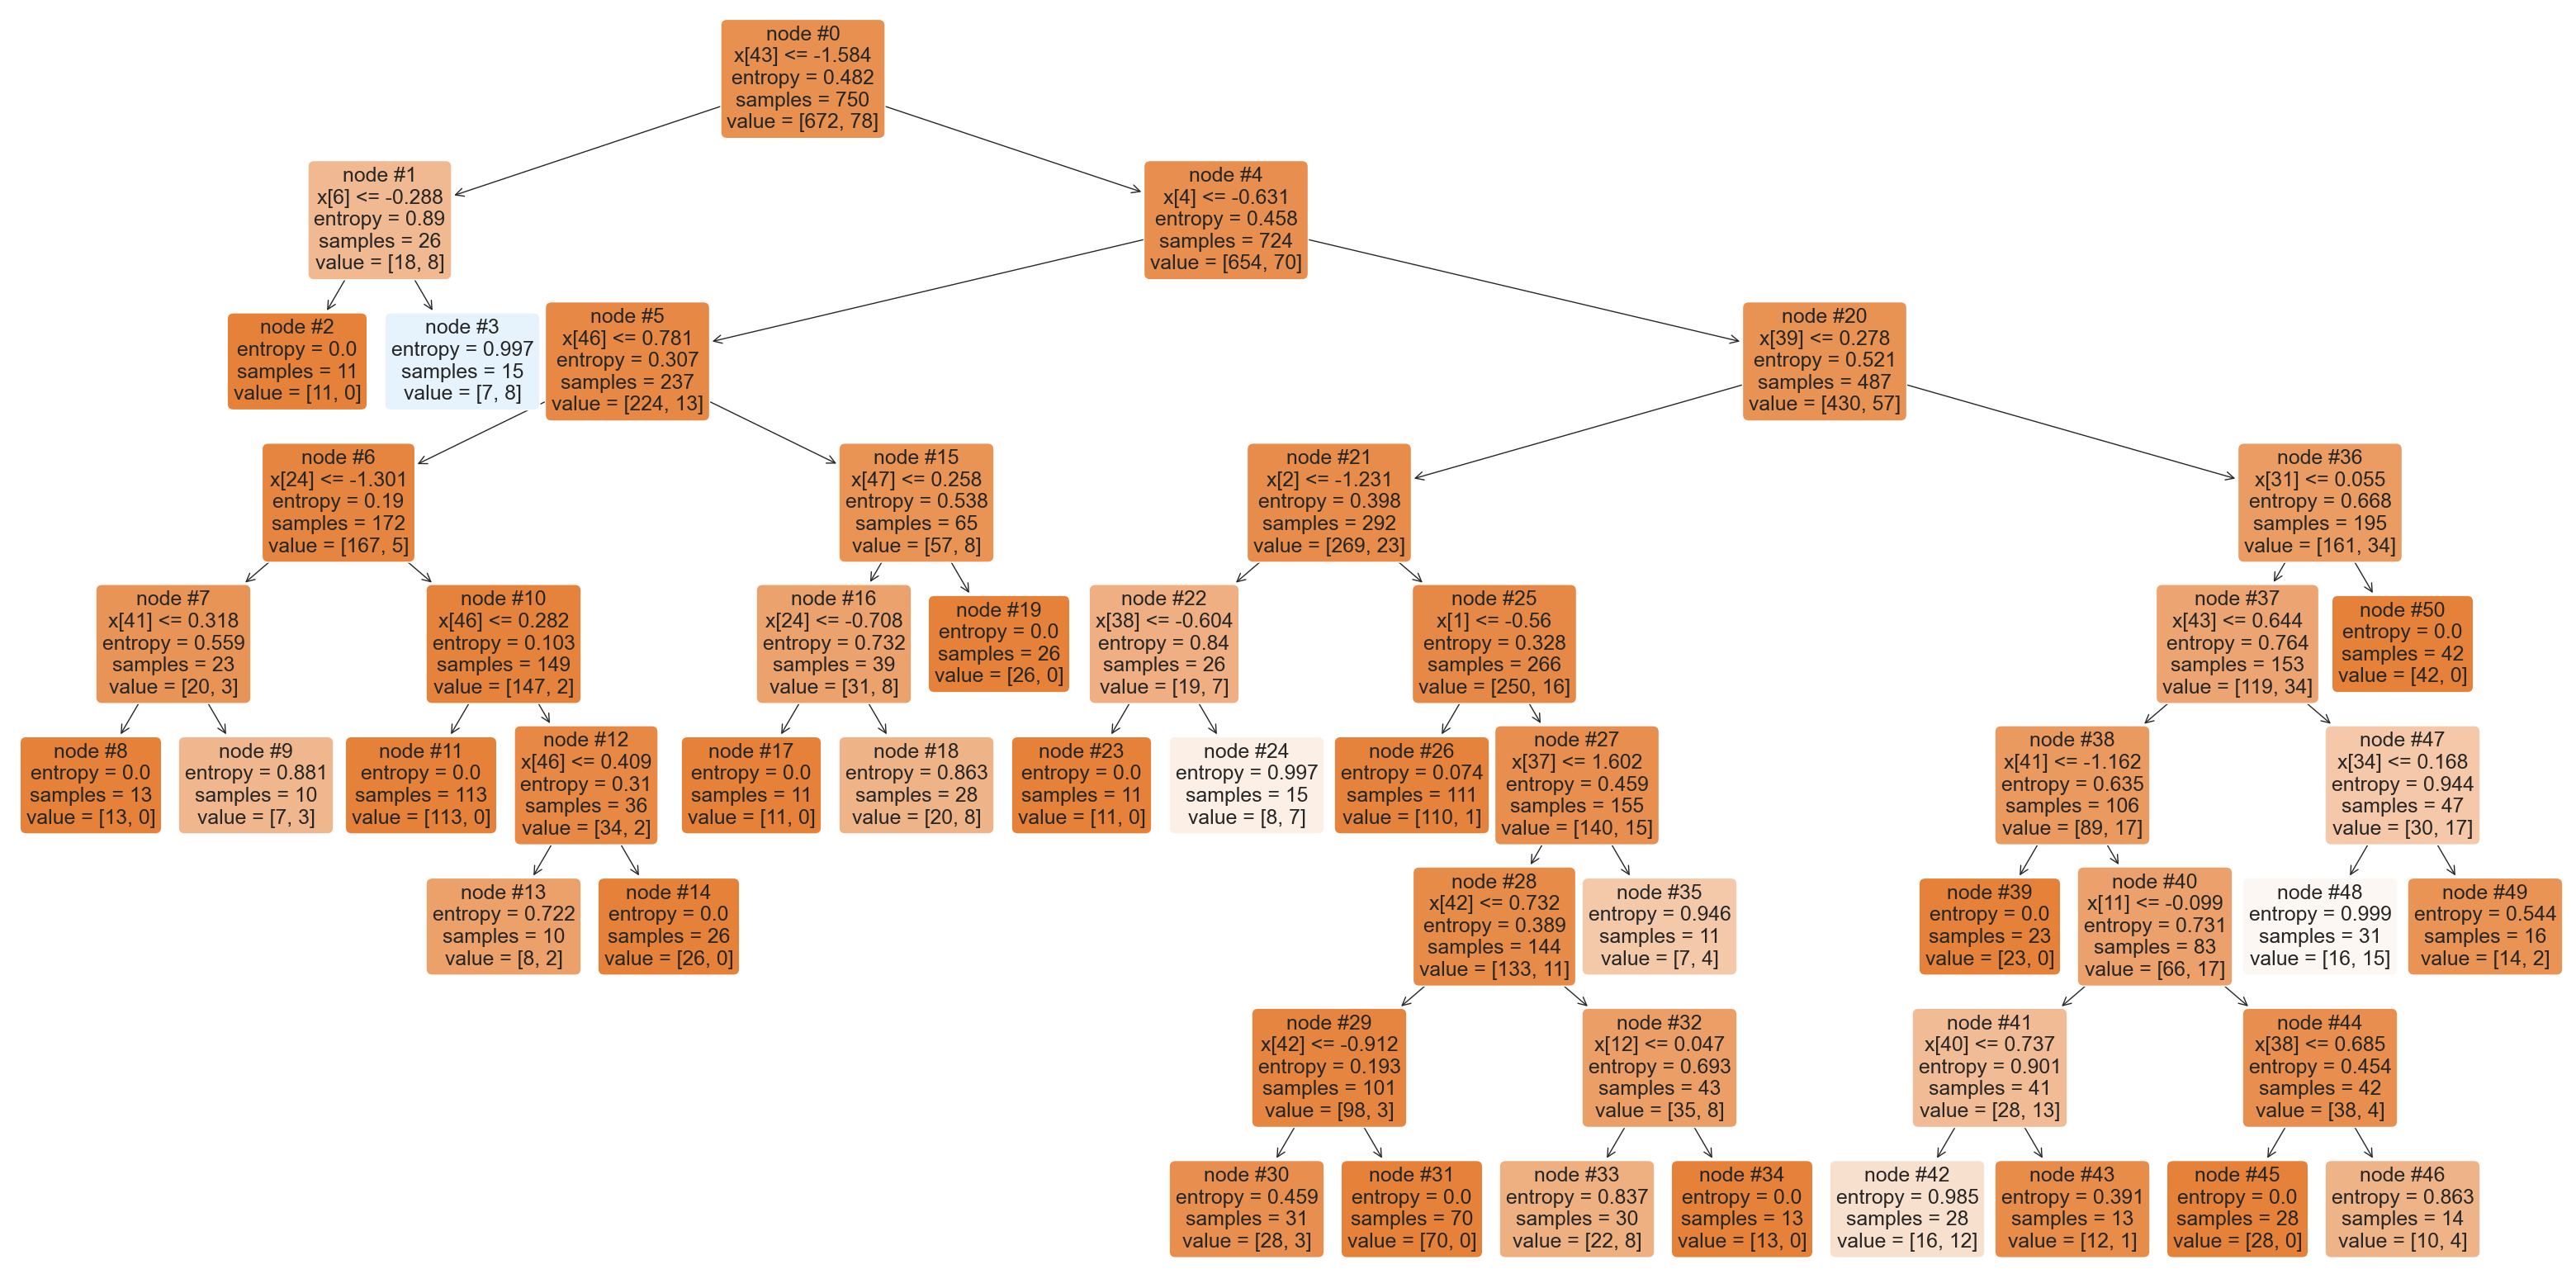

In [43]:
plt.figure(figsize=(40,20))
plot_tree(
    final_clf,
    max_depth=None,
    feature_names=None,
    class_names=None,
    label='all',
    filled=True,
    impurity=True,
    node_ids=True,
    proportion=False,
    rounded=True,
    precision=3,
    ax=None,
    fontsize=None
)
plt.savefig(DT_FULLCOMPLETE_FIG_OUT, format='jpg');

#### Full, schema

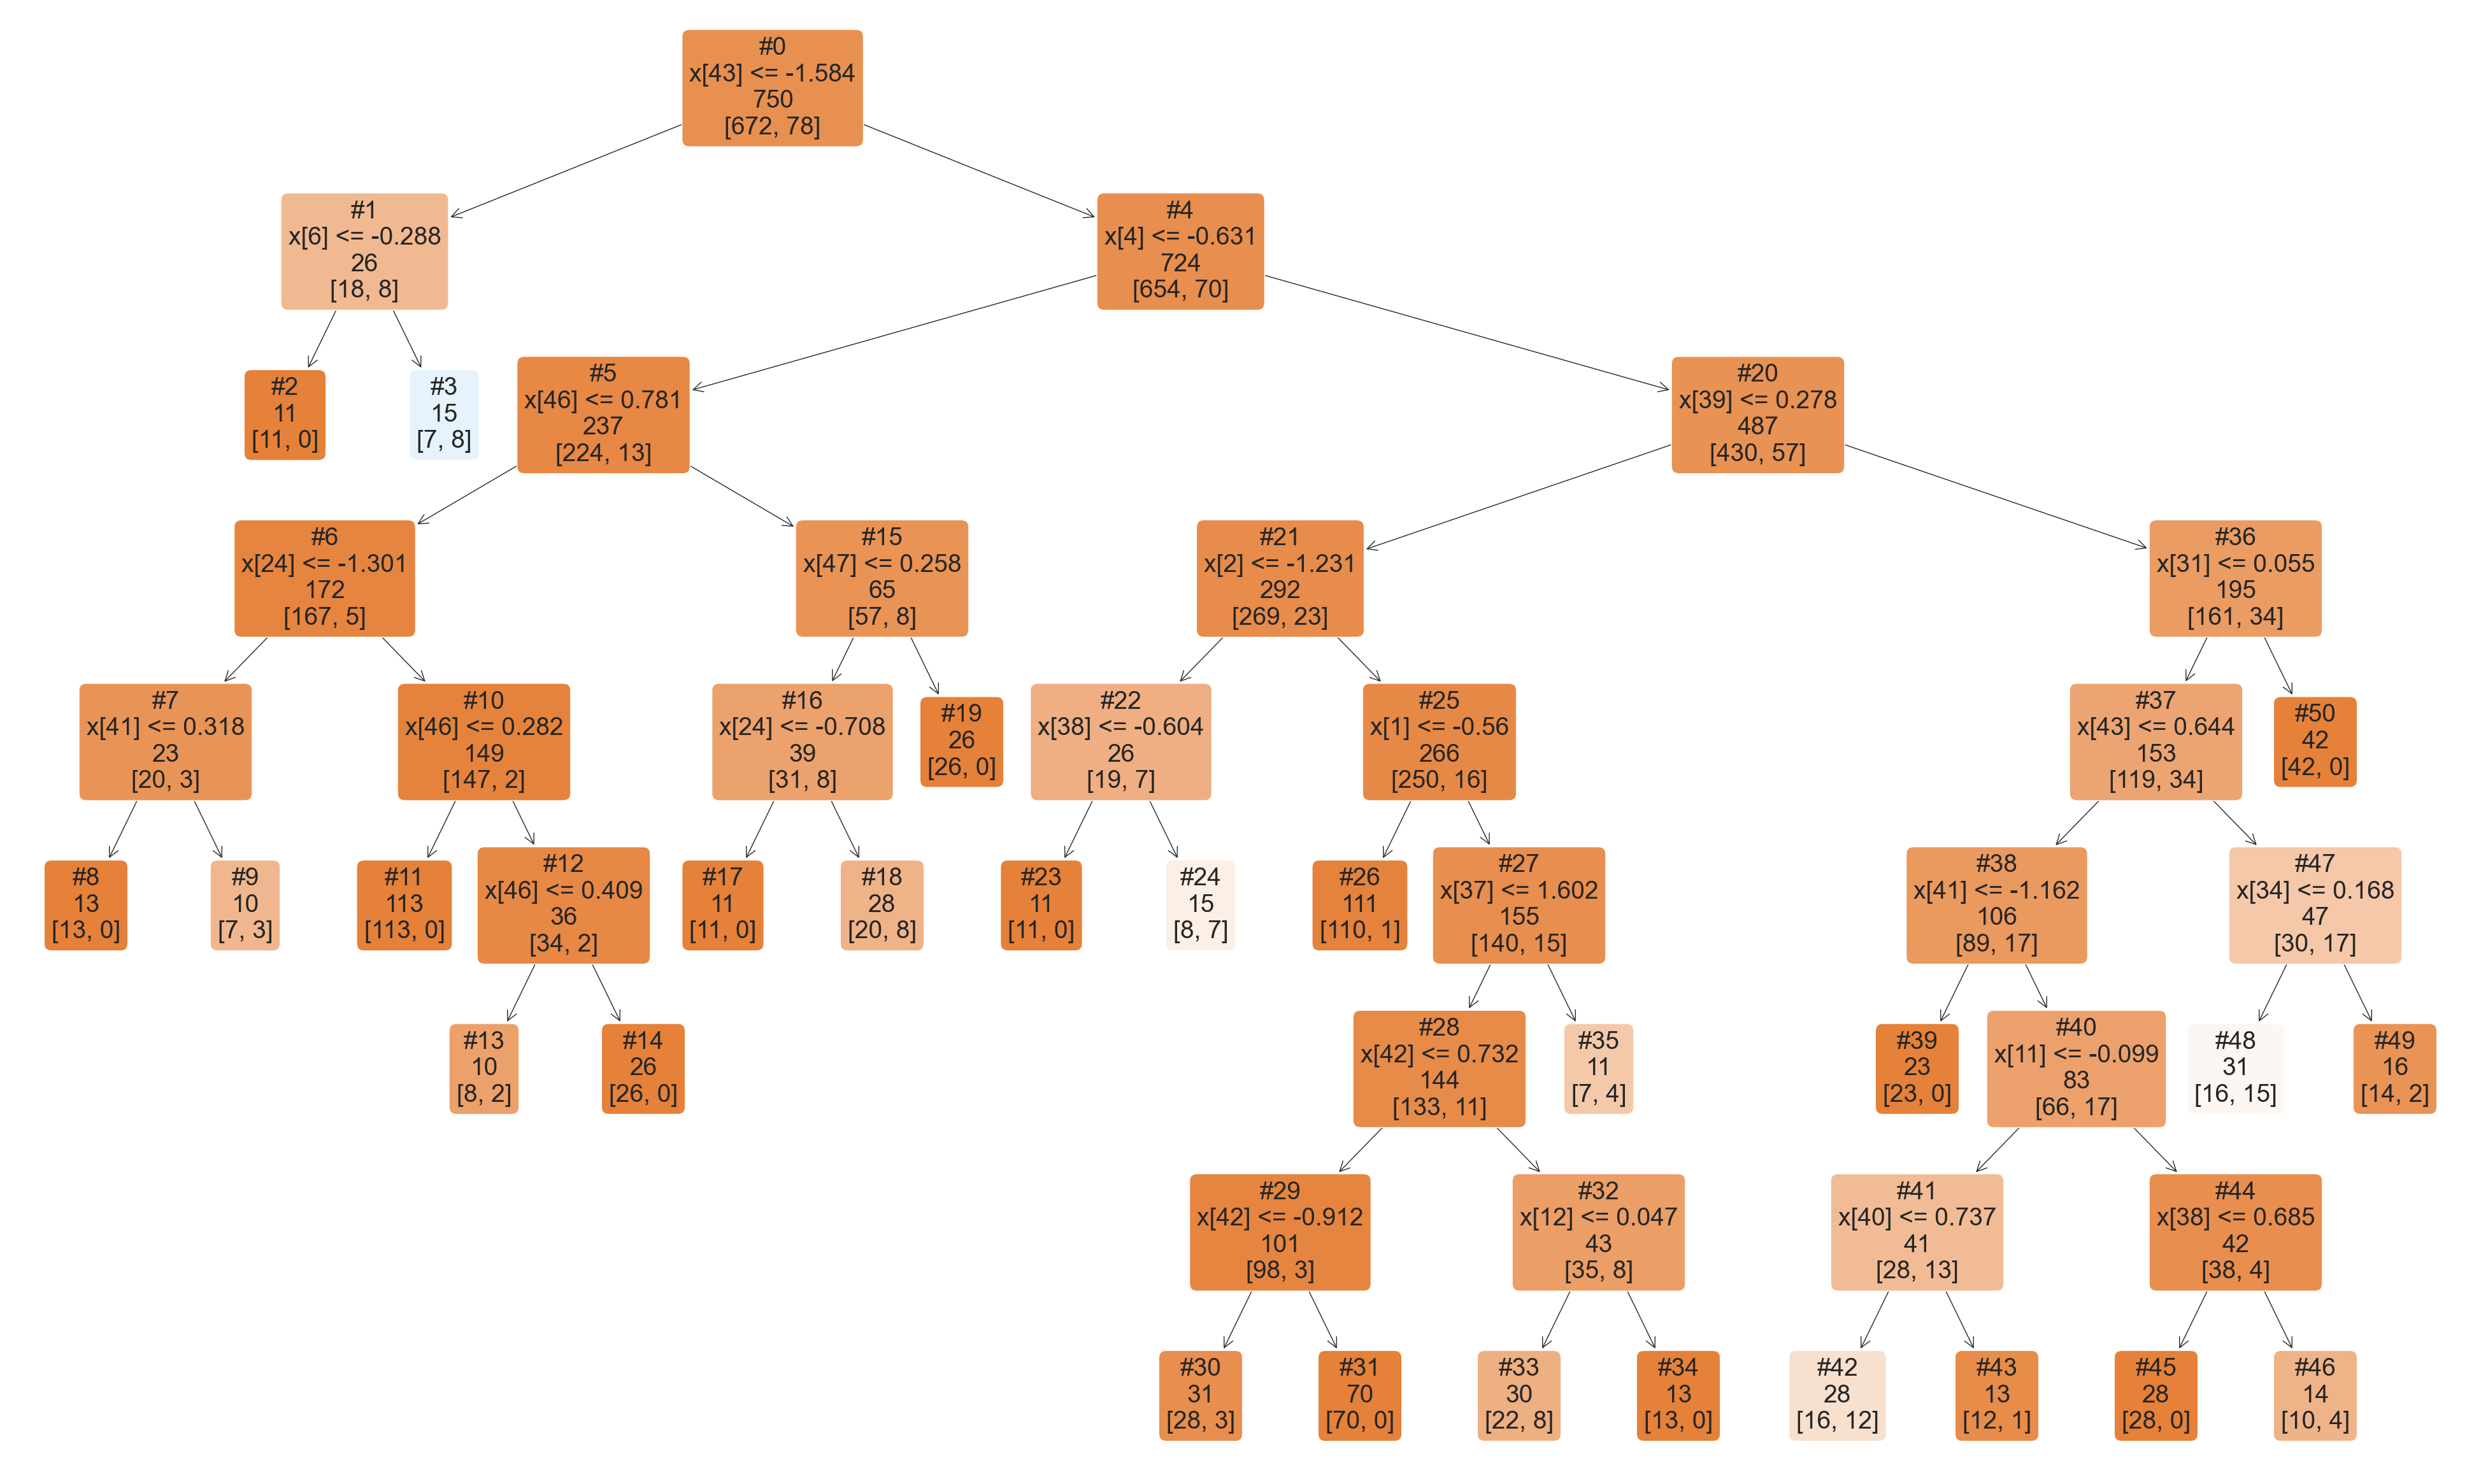

In [44]:
plt.figure(figsize=(50,30))
plot_tree(
    final_clf,
    max_depth=None,
    feature_names=None,
    class_names=None,
    label=None,
    filled=True,
    impurity=False,
    node_ids=True,
    proportion=False,
    rounded=True,
    precision=3,
    ax=None,
    fontsize=28
)
plt.savefig(DT_FULLSCHEMA_FIG_OUT, format='jpg');

##### Key

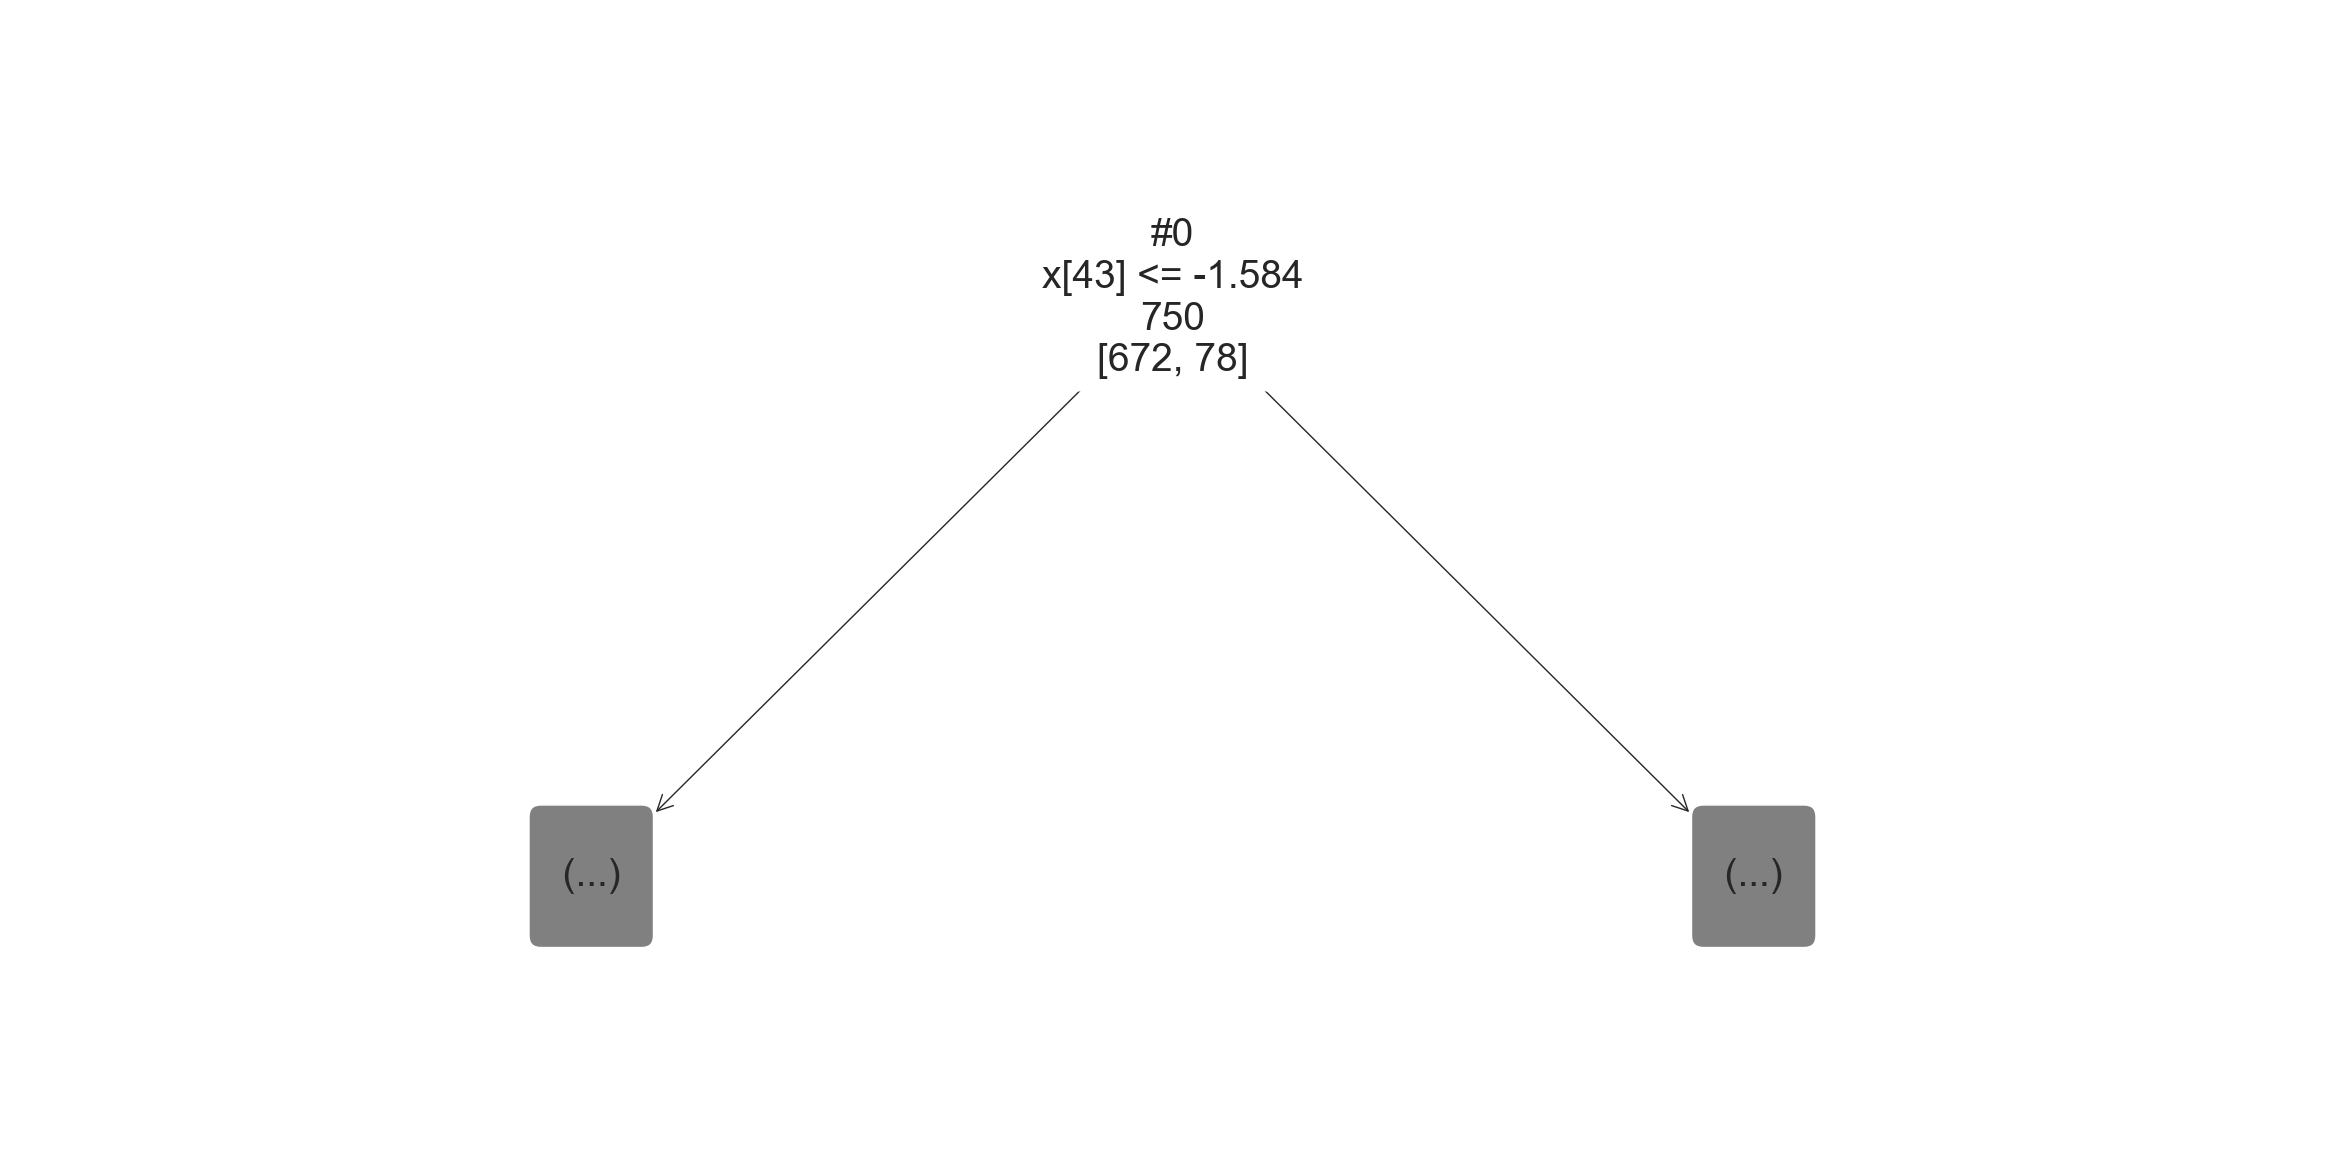

In [45]:
plt.figure(figsize=(30, 15))
plot_tree(
    final_clf,
    max_depth=0,
    feature_names=None,
    class_names=None,
    label=None,
    filled=False,
    impurity=False,
    node_ids=True,
    proportion=False,
    rounded=True,
    precision=3,
    ax=None,
    fontsize=28
)
plt.savefig(DT_FIGKEY1_OUT, format='jpg');

#### With `max_depth` = 2

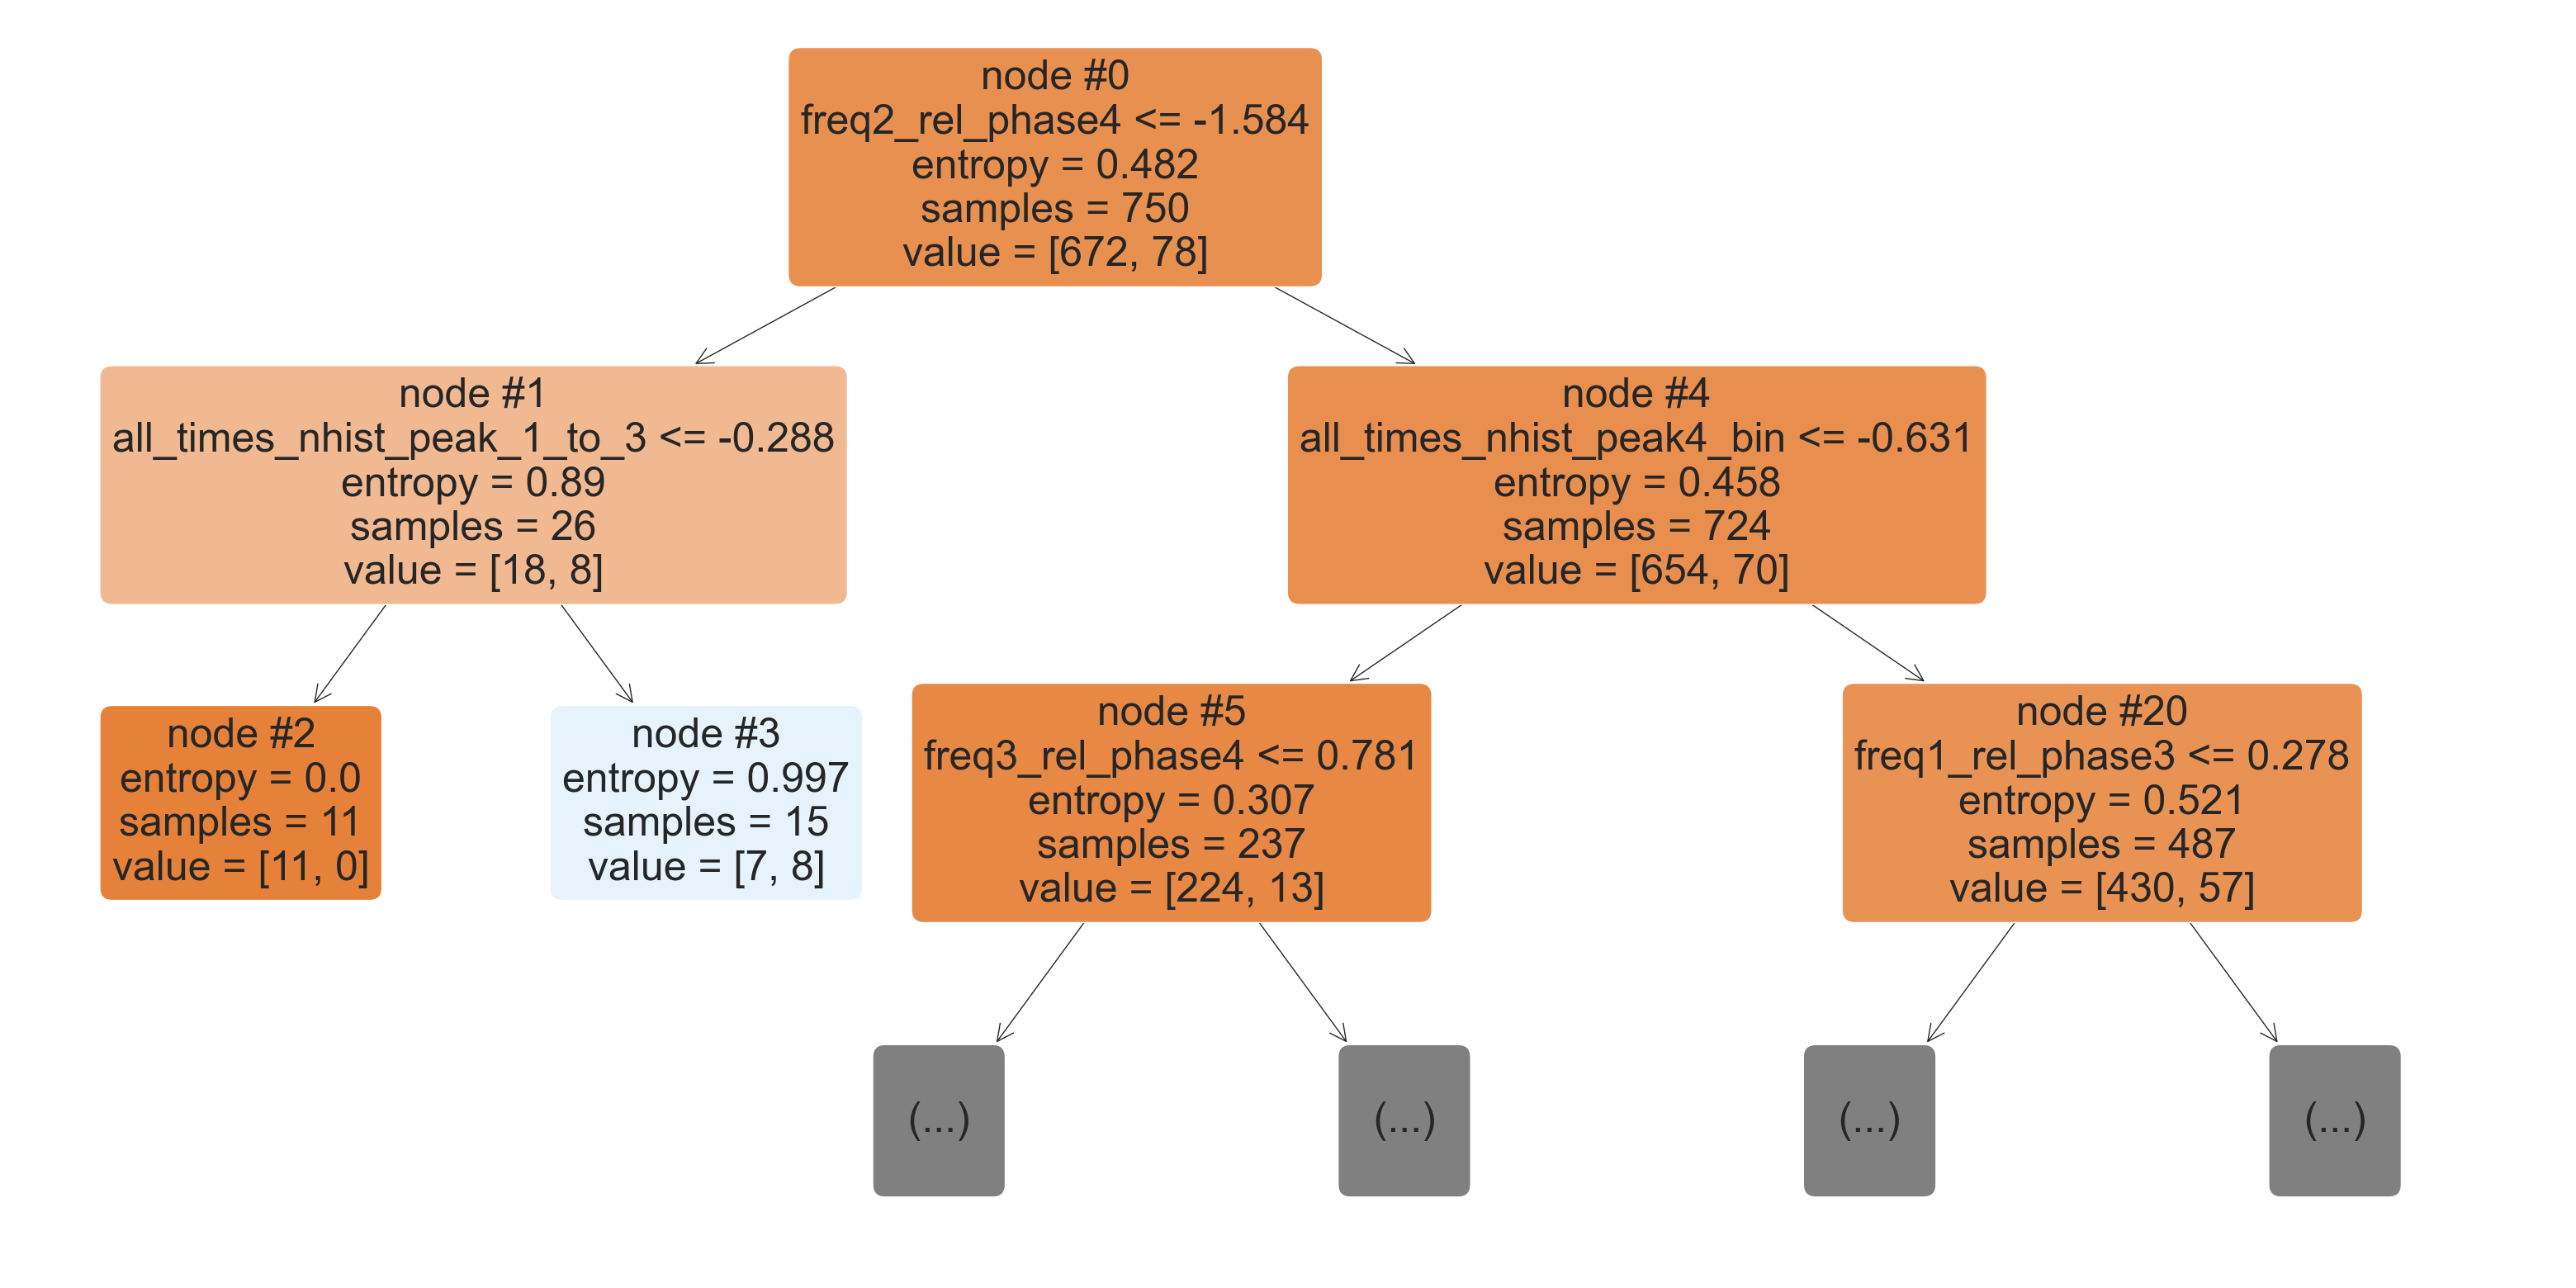

In [46]:
plt.figure(figsize=(40, 20))
plot_tree(
    final_clf,
    max_depth=2,
    feature_names=final_clf.feature_names_in_,
    class_names=None,
    label='all',
    filled=True,
    impurity=True,
    node_ids=True,
    proportion=False,
    rounded=True,
    precision=3,
    ax=None,
    fontsize=36
)
plt.savefig(DT_MD2_FIG_OUT, format='jpg');

##### Key

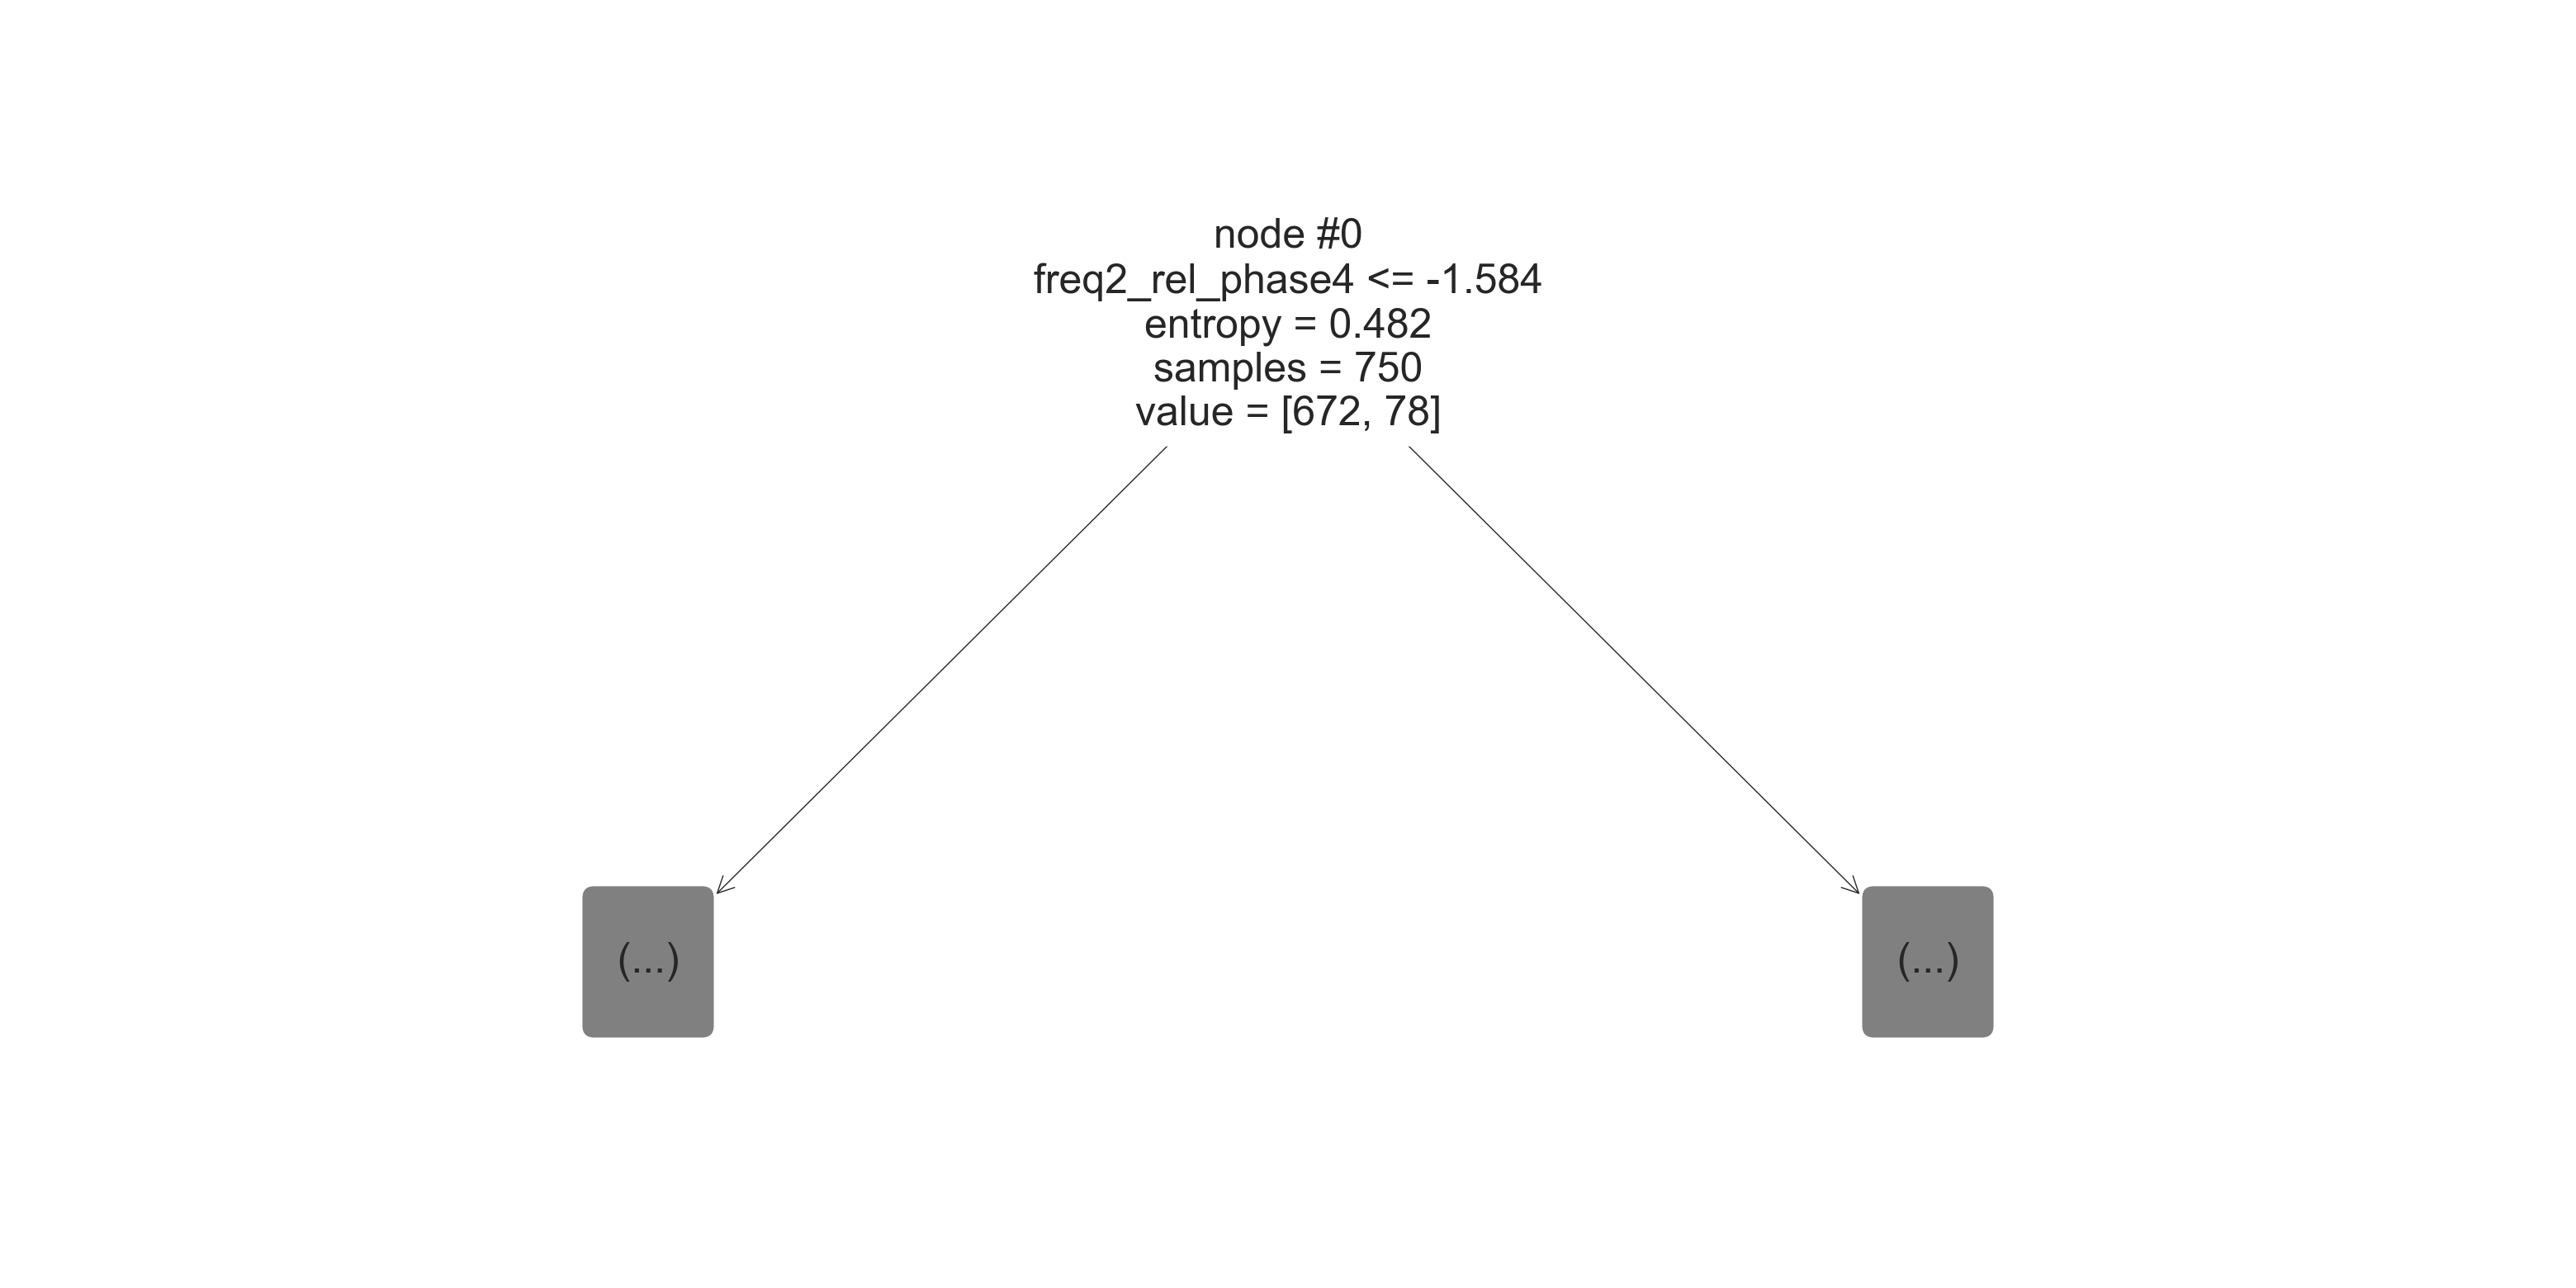

In [47]:
plt.figure(figsize=(40,20))
plot_tree(
    final_clf,
    max_depth=0,
    feature_names=final_clf.feature_names_in_,
    class_names=None,
    label='all',
    filled=False,
    impurity=True,
    node_ids=True,
    proportion=False,
    rounded=True,
    precision=3,
    ax=None,
    fontsize=36
)
plt.savefig(DT_FIGKEY2_OUT, format='jpg');

### Feature importance

In [48]:
final_clf.feature_importances_

array([0.        , 0.05335173, 0.04745253, 0.        , 0.03747354,
       0.        , 0.05515932, 0.        , 0.        , 0.        ,
       0.        , 0.0316615 , 0.03164756, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.05959072,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.08915158, 0.        , 0.        , 0.03160099,
       0.        , 0.        , 0.03114912, 0.09328862, 0.04902369,
       0.02875651, 0.07167629, 0.08097533, 0.07631868, 0.        ,
       0.        , 0.08848369, 0.04323861])

In [49]:
final_clf.feature_names_in_

array(['all_times_nhist_numpeaks', 'all_times_nhist_peak1_bin',
       'all_times_nhist_peak2_bin', 'all_times_nhist_peak3_bin',
       'all_times_nhist_peak4_bin', 'all_times_nhist_peak_1_to_2',
       'all_times_nhist_peak_1_to_3', 'all_times_nhist_peak_1_to_4',
       'all_times_nhist_peak_2_to_3', 'all_times_nhist_peak_2_to_4',
       'all_times_nhist_peak_3_to_4', 'all_times_nhist_peak_val',
       'avg_double_to_single_step', 'cad_probs_1', 'cad_probs_10',
       'cad_probs_20', 'cad_probs_30', 'cad_probs_40', 'cad_probs_50',
       'cad_probs_100', 'cad_probs_500', 'cad_probs_1000',
       'cad_probs_5000', 'cad_probs_10000', 'cad_probs_50000',
       'cad_probs_100000', 'cad_probs_500000', 'cad_probs_1000000',
       'cad_probs_5000000', 'cad_probs_10000000', 'cads_avg', 'cads_med',
       'cads_std', 'med_double_to_single_step', 'n_epochs',
       'std_double_to_single_step', 'total_time', 'percent_beyond_1_std',
       'freq1_rel_phase2', 'freq1_rel_phase3', 'freq1_rel_phase4

And the relevant features are:

In [50]:
feature_importances = [(a, b) for (a, b) in zip(final_clf.feature_names_in_, final_clf.feature_importances_)]
print(feature_importances)

[('all_times_nhist_numpeaks', 0.0), ('all_times_nhist_peak1_bin', 0.053351732839712354), ('all_times_nhist_peak2_bin', 0.04745253255262875), ('all_times_nhist_peak3_bin', 0.0), ('all_times_nhist_peak4_bin', 0.0374735424302233), ('all_times_nhist_peak_1_to_2', 0.0), ('all_times_nhist_peak_1_to_3', 0.055159316528155804), ('all_times_nhist_peak_1_to_4', 0.0), ('all_times_nhist_peak_2_to_3', 0.0), ('all_times_nhist_peak_2_to_4', 0.0), ('all_times_nhist_peak_3_to_4', 0.0), ('all_times_nhist_peak_val', 0.031661495131439336), ('avg_double_to_single_step', 0.031647560604420526), ('cad_probs_1', 0.0), ('cad_probs_10', 0.0), ('cad_probs_20', 0.0), ('cad_probs_30', 0.0), ('cad_probs_40', 0.0), ('cad_probs_50', 0.0), ('cad_probs_100', 0.0), ('cad_probs_500', 0.0), ('cad_probs_1000', 0.0), ('cad_probs_5000', 0.0), ('cad_probs_10000', 0.0), ('cad_probs_50000', 0.059590721245794245), ('cad_probs_100000', 0.0), ('cad_probs_500000', 0.0), ('cad_probs_1000000', 0.0), ('cad_probs_5000000', 0.0), ('cad_pr

In [51]:
important_features = sorted([(elem[0], elem[1]) for elem in feature_importances if elem[1] > 0.0],
                           key=lambda x: x[1], reverse=True)
important_features

[('freq1_rel_phase2', 0.09328862005145015),
 ('cads_med', 0.08915158085255727),
 ('freq3_rel_phase4', 0.08848368750165665),
 ('freq2_rel_phase3', 0.08097533036757894),
 ('freq2_rel_phase4', 0.07631867650916775),
 ('freq2_rel_phase2', 0.07167629217565205),
 ('cad_probs_50000', 0.059590721245794245),
 ('all_times_nhist_peak_1_to_3', 0.055159316528155804),
 ('all_times_nhist_peak1_bin', 0.053351732839712354),
 ('freq1_rel_phase3', 0.04902369268111699),
 ('all_times_nhist_peak2_bin', 0.04745253255262875),
 ('freq_model_phi1_phi2', 0.043238609453108104),
 ('all_times_nhist_peak4_bin', 0.0374735424302233),
 ('all_times_nhist_peak_val', 0.031661495131439336),
 ('avg_double_to_single_step', 0.031647560604420526),
 ('n_epochs', 0.03160098627192034),
 ('percent_beyond_1_std', 0.03114911737675533),
 ('freq1_rel_phase4', 0.028756505426662093)]

In [52]:
sum([elem[1] for elem in important_features])

0.9999999999999998

In [53]:
important_features_df = pd.DataFrame(
    important_features, columns=['Feature', 'Relative importance']
)
important_features_df['Relative importance'] = important_features_df['Relative importance'] \
    .map(lambda x: np.round( x, 3))
important_features_df

,Feature,Relative importance
0,freq1_rel_phase2,0.093
1,cads_med,0.089
2,freq3_rel_phase4,0.088
3,freq2_rel_phase3,0.081
4,freq2_rel_phase4,0.076
5,freq2_rel_phase2,0.072
6,cad_probs_50000,0.060
7,all_times_nhist_peak_1_to_3,0.055
8,all_times_nhist_peak1_bin,0.053
9,freq1_rel_phase3,0.049


#### Add the type and description fields

In [54]:
important_features_df = important_features_df.merge(cesium_info, how='left', on='Feature')
important_features_df

,Feature,Relative importance,Type,Description
0,freq1_rel_phase2,0.093,Lomb-Scargle (periodic),Get the relative phase of the jth harmonic of ...
1,cads_med,0.089,Cadence/Error,Median value of cads (discrete difference betw...
2,freq3_rel_phase4,0.088,Lomb-Scargle (periodic),Get the relative phase of the jth harmonic of ...
3,freq2_rel_phase3,0.081,Lomb-Scargle (periodic),Get the relative phase of the jth harmonic of ...
4,freq2_rel_phase4,0.076,Lomb-Scargle (periodic),Get the relative phase of the jth harmonic of ...
5,freq2_rel_phase2,0.072,Lomb-Scargle (periodic),Get the relative phase of the jth harmonic of ...
6,cad_probs_50000,0.060,Cadence/Error,Given the observed distribution of time lags c...
7,all_times_nhist_peak_1_to_3,0.055,Cadence/Error,Compute the ratio of the values of the ith and...
8,all_times_nhist_peak1_bin,0.053,Cadence/Error,Return the (bin) index of the ith largest peak...
9,freq1_rel_phase3,0.049,Lomb-Scargle (periodic),Get the relative phase of the jth harmonic of ...


#### Save important features to file and LaTeX

In [55]:
important_features_df.to_csv(IMPORTANT_FEATURES_OUT, sep=';', decimal='.')

In [56]:
# LaTeX print to screen:
pd.set_option('display.max_colwidth', None)
print(
    important_features_df.to_latex(
        index=False, longtable=True,
        caption=("Important features.",
                 "Important features.")
    )
)
# Restore default:
pd.set_option('display.max_colwidth', 50)

\begin{longtable}{lrll}
\caption[Important features.]{Important features.}\\
\toprule
                    Feature &  Relative importance &                    Type &                                                                                                                                                                        Description \\
\midrule
\endfirsthead
\caption[]{Important features.} \\
\toprule
                    Feature &  Relative importance &                    Type &                                                                                                                                                                        Description \\
\midrule
\endhead
\midrule
\multicolumn{4}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
           freq1\_rel\_phase2 &                0.093 & Lomb-Scargle (periodic) &                                                                                  Get the relative phase of the jth harmonic o

C:\Users\ciroe\AppData\Local\Temp\ipykernel_1256\3422357935.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  important_features_df.to_latex(


In [57]:
# Write to file:
pd.set_option('display.max_colwidth', None)
# Backup the standard output:
original_stdout = sys.stdout
with open(IMPORTANT_FEATURES_LATEX_OUT, 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.print(
    print(
        important_features_df.to_latex(
            index=False, longtable=True,
            caption=("Important features.",
                     "Important features.")
        )
    )
# Restore the standard output to its original value
sys.stdout = original_stdout
# Restore default:
pd.set_option('display.max_colwidth', 50)

C:\Users\ciroe\AppData\Local\Temp\ipykernel_1256\1392021437.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  important_features_df.to_latex(


### Predicition probabilities

#### Distribution for training sample true classes (density)

In [58]:
tr_results.head()

,ID,Pulsating,Pulsation predicted,Pulsation probability,frequency,amplitudeRV,offsetRV,refepochRV,phase,S1_Ps,...,S3_Ps_median,S3_Ps_stdev,S3_NumPoints,S4_errorRV_mean,S4_errorRV_median,S4_errorRV_stdev,S1_file,S2_file,S3_file,S4_file
0,Star-00163,0,0,0.000000,0.0,0.00,0.0,2.457444e+06,0.00,0.0016,...,16.934754,176.814033,19,1.827368,1.730,0.656497,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
1,Star-00123,1,0,0.266667,30.0,0.72,0.0,2.457401e+06,0.37,0.0016,...,19.921451,236.293295,19,1.526316,1.430,0.330680,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
2,Star-00022,0,0,0.000000,0.0,0.00,0.0,2.457430e+06,0.00,0.0016,...,3.502830,42.237370,55,1.805455,1.830,0.370552,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
3,Star-00708,0,0,0.000000,0.0,0.00,0.0,2.459677e+06,0.00,0.0016,...,0.903694,18.966698,64,1.394062,1.260,0.304152,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
4,Star-00484,0,0,0.000000,0.0,0.00,0.0,2.457400e+06,0.00,0.0016,...,9.939187,97.314974,50,1.216600,1.205,0.092857,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...


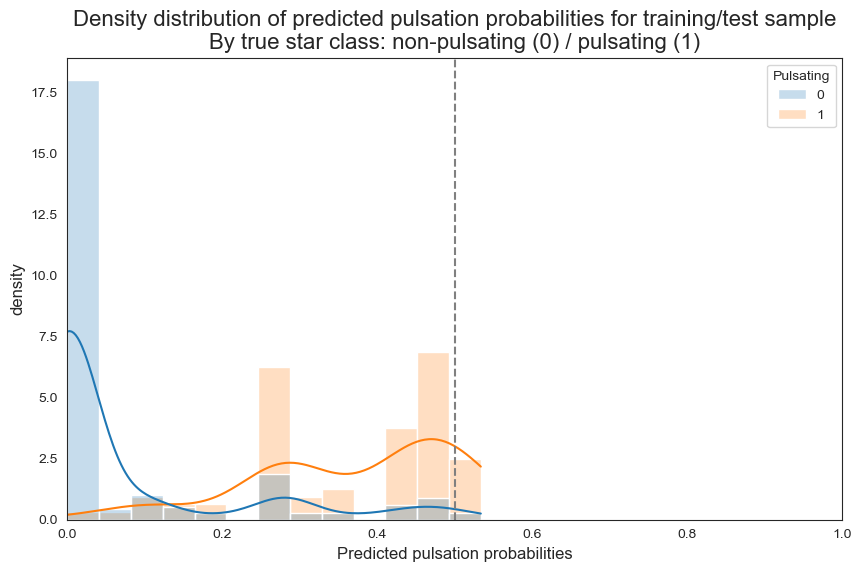

In [59]:
data = tr_results
x_col = 'Pulsation probability'
hue_col = 'Pulsating'
prob_threshold = 0.5
varname = "Predicted pulsation probabilities"
fig_title = "Density distribution of predicted pulsation probabilities for training/test sample\n" \
    "By true star class: non-pulsating (0) / pulsating (1)"
fig_filename = IMG_FOLDER + "ML_90_01_DistrDensity_ProbTraining.jpg"
stat = 'density'
kde = True
hist_fill = True
bins = 'auto'

compare_dist(
    data=data, x_col=x_col, hue_col=hue_col,
    prob_threshold=prob_threshold, varname=varname,
    fig_title=fig_title, fig_filename=fig_filename,
    stat=stat, kde=kde, hist_fill=hist_fill, bins=bins
)


#### Distribution for training sample true classes (count)

In [60]:
tr_results.head()

,ID,Pulsating,Pulsation predicted,Pulsation probability,frequency,amplitudeRV,offsetRV,refepochRV,phase,S1_Ps,...,S3_Ps_median,S3_Ps_stdev,S3_NumPoints,S4_errorRV_mean,S4_errorRV_median,S4_errorRV_stdev,S1_file,S2_file,S3_file,S4_file
0,Star-00163,0,0,0.000000,0.0,0.00,0.0,2.457444e+06,0.00,0.0016,...,16.934754,176.814033,19,1.827368,1.730,0.656497,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
1,Star-00123,1,0,0.266667,30.0,0.72,0.0,2.457401e+06,0.37,0.0016,...,19.921451,236.293295,19,1.526316,1.430,0.330680,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
2,Star-00022,0,0,0.000000,0.0,0.00,0.0,2.457430e+06,0.00,0.0016,...,3.502830,42.237370,55,1.805455,1.830,0.370552,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
3,Star-00708,0,0,0.000000,0.0,0.00,0.0,2.459677e+06,0.00,0.0016,...,0.903694,18.966698,64,1.394062,1.260,0.304152,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
4,Star-00484,0,0,0.000000,0.0,0.00,0.0,2.457400e+06,0.00,0.0016,...,9.939187,97.314974,50,1.216600,1.205,0.092857,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...


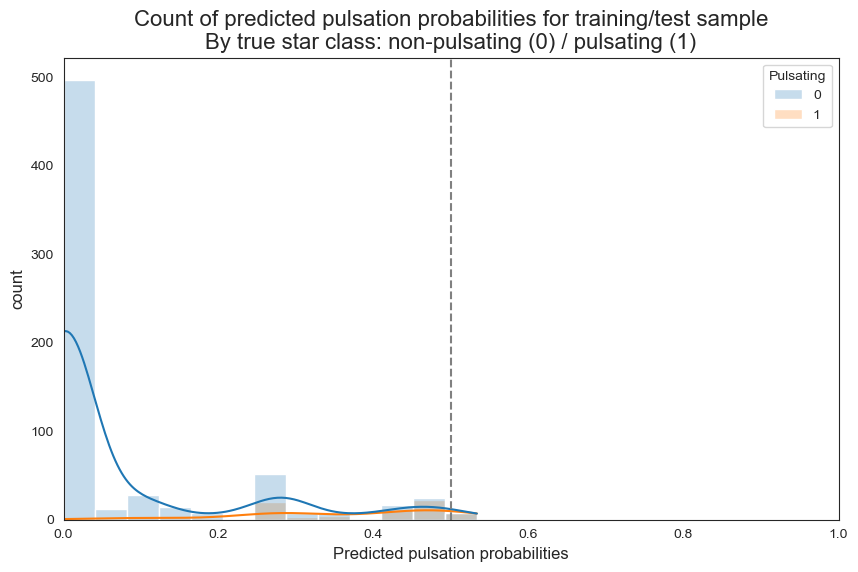

In [61]:
data = tr_results
x_col = 'Pulsation probability'
hue_col = 'Pulsating'
prob_threshold = 0.5
varname = "Predicted pulsation probabilities"
fig_title = "Count of predicted pulsation probabilities for training/test sample\n" \
    "By true star class: non-pulsating (0) / pulsating (1)"
fig_filename = IMG_FOLDER + "ML_90_02_DistrCount_ProbTraining.jpg"
stat = 'count'
kde = True
hist_fill = True
bins = 'auto'

compare_dist(
    data=data, x_col=x_col, hue_col=hue_col,
    prob_threshold=prob_threshold, varname=varname,
    fig_title=fig_title, fig_filename=fig_filename,
    stat=stat, kde=kde, hist_fill=hist_fill, bins=bins
)


#### Distribution for validation sample true classes (density)

In [62]:
val_results.head()

,ID,Pulsating,Pulsation predicted,Pulsation probability,frequency,amplitudeRV,offsetRV,refepochRV,phase,S1_Ps,...,S3_Ps_median,S3_Ps_stdev,S3_NumPoints,S4_errorRV_mean,S4_errorRV_median,S4_errorRV_stdev,S1_file,S2_file,S3_file,S4_file
0,Star-00107,0,0,0.363636,0.0,0.0,0.0,2.457430e+06,0.0,0.0016,...,8.496524,198.804473,11,1.571818,1.430,0.420148,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
1,Star-00868,0,0,0.000000,0.0,0.0,0.0,2.457432e+06,0.0,0.0016,...,15.468968,351.136147,9,1.453333,1.380,0.447412,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
2,Star-00106,0,0,0.000000,0.0,0.0,0.0,2.457404e+06,0.0,0.0016,...,2.991639,42.269476,118,1.548729,1.500,0.344921,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
3,Star-00120,0,0,0.000000,0.0,0.0,0.0,2.457395e+06,0.0,0.0016,...,20.972757,130.800882,22,1.476364,1.325,0.419551,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
4,Star-00559,0,0,0.009009,0.0,0.0,0.0,2.457441e+06,0.0,0.0016,...,10.074961,40.909038,66,1.350909,1.330,0.162236,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...


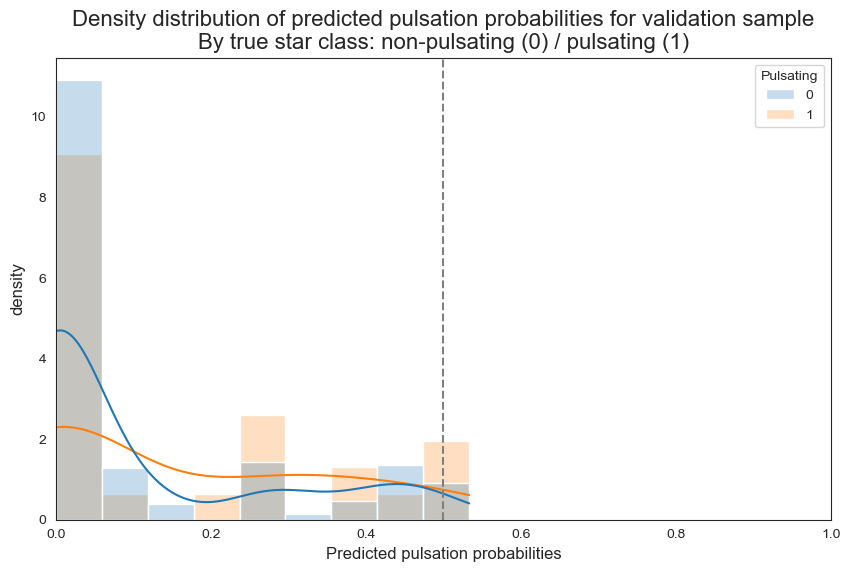

In [63]:
data = val_results
x_col = 'Pulsation probability'
hue_col = 'Pulsating'
prob_threshold = 0.5
varname = "Predicted pulsation probabilities"
fig_title = "Density distribution of predicted pulsation probabilities for validation sample\n" \
    "By true star class: non-pulsating (0) / pulsating (1)"
fig_filename = IMG_FOLDER + "ML_90_03_DistrDensity_ProbValidation.jpg"
stat = 'density'
kde = True
hist_fill = True
bins = 'auto'

compare_dist(
    data=data, x_col=x_col, hue_col=hue_col,
    prob_threshold=prob_threshold, varname=varname,
    fig_title=fig_title, fig_filename=fig_filename,
    stat=stat, kde=kde, hist_fill=hist_fill, bins=bins
)


#### Distribution for validation sample true classes (count)

In [64]:
val_results.head()

,ID,Pulsating,Pulsation predicted,Pulsation probability,frequency,amplitudeRV,offsetRV,refepochRV,phase,S1_Ps,...,S3_Ps_median,S3_Ps_stdev,S3_NumPoints,S4_errorRV_mean,S4_errorRV_median,S4_errorRV_stdev,S1_file,S2_file,S3_file,S4_file
0,Star-00107,0,0,0.363636,0.0,0.0,0.0,2.457430e+06,0.0,0.0016,...,8.496524,198.804473,11,1.571818,1.430,0.420148,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
1,Star-00868,0,0,0.000000,0.0,0.0,0.0,2.457432e+06,0.0,0.0016,...,15.468968,351.136147,9,1.453333,1.380,0.447412,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
2,Star-00106,0,0,0.000000,0.0,0.0,0.0,2.457404e+06,0.0,0.0016,...,2.991639,42.269476,118,1.548729,1.500,0.344921,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
3,Star-00120,0,0,0.000000,0.0,0.0,0.0,2.457395e+06,0.0,0.0016,...,20.972757,130.800882,22,1.476364,1.325,0.419551,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
4,Star-00559,0,0,0.009009,0.0,0.0,0.0,2.457441e+06,0.0,0.0016,...,10.074961,40.909038,66,1.350909,1.330,0.162236,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...


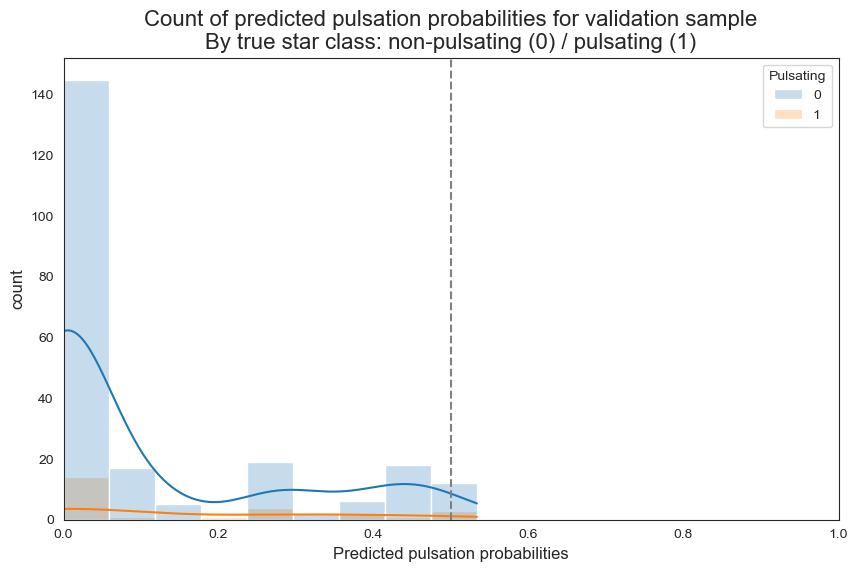

In [65]:
data = val_results
x_col = 'Pulsation probability'
hue_col = 'Pulsating'
prob_threshold = 0.5
varname = "Predicted pulsation probabilities"
fig_title = "Count of predicted pulsation probabilities for validation sample\n" \
    "By true star class: non-pulsating (0) / pulsating (1)"
fig_filename = IMG_FOLDER + "ML_90_04_DistrCount_ProbValidation.jpg"
stat = 'count'
kde = True
hist_fill = True
bins = 'auto'

compare_dist(
    data=data, x_col=x_col, hue_col=hue_col,
    prob_threshold=prob_threshold, varname=varname,
    fig_title=fig_title, fig_filename=fig_filename,
    stat=stat, kde=kde, hist_fill=hist_fill, bins=bins
)


#### Threshold impact on predicted pulsating stars

In [66]:
val_results.head()

,ID,Pulsating,Pulsation predicted,Pulsation probability,frequency,amplitudeRV,offsetRV,refepochRV,phase,S1_Ps,...,S3_Ps_median,S3_Ps_stdev,S3_NumPoints,S4_errorRV_mean,S4_errorRV_median,S4_errorRV_stdev,S1_file,S2_file,S3_file,S4_file
0,Star-00107,0,0,0.363636,0.0,0.0,0.0,2.457430e+06,0.0,0.0016,...,8.496524,198.804473,11,1.571818,1.430,0.420148,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
1,Star-00868,0,0,0.000000,0.0,0.0,0.0,2.457432e+06,0.0,0.0016,...,15.468968,351.136147,9,1.453333,1.380,0.447412,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
2,Star-00106,0,0,0.000000,0.0,0.0,0.0,2.457404e+06,0.0,0.0016,...,2.991639,42.269476,118,1.548729,1.500,0.344921,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
3,Star-00120,0,0,0.000000,0.0,0.0,0.0,2.457395e+06,0.0,0.0016,...,20.972757,130.800882,22,1.476364,1.325,0.419551,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
4,Star-00559,0,0,0.009009,0.0,0.0,0.0,2.457441e+06,0.0,0.0016,...,10.074961,40.909038,66,1.350909,1.330,0.162236,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...


In [67]:
val_result_w_thr = val_results.copy()
val_result_w_thr.head()

,ID,Pulsating,Pulsation predicted,Pulsation probability,frequency,amplitudeRV,offsetRV,refepochRV,phase,S1_Ps,...,S3_Ps_median,S3_Ps_stdev,S3_NumPoints,S4_errorRV_mean,S4_errorRV_median,S4_errorRV_stdev,S1_file,S2_file,S3_file,S4_file
0,Star-00107,0,0,0.363636,0.0,0.0,0.0,2.457430e+06,0.0,0.0016,...,8.496524,198.804473,11,1.571818,1.430,0.420148,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
1,Star-00868,0,0,0.000000,0.0,0.0,0.0,2.457432e+06,0.0,0.0016,...,15.468968,351.136147,9,1.453333,1.380,0.447412,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
2,Star-00106,0,0,0.000000,0.0,0.0,0.0,2.457404e+06,0.0,0.0016,...,2.991639,42.269476,118,1.548729,1.500,0.344921,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
3,Star-00120,0,0,0.000000,0.0,0.0,0.0,2.457395e+06,0.0,0.0016,...,20.972757,130.800882,22,1.476364,1.325,0.419551,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...
4,Star-00559,0,0,0.009009,0.0,0.0,0.0,2.457441e+06,0.0,0.0016,...,10.074961,40.909038,66,1.350909,1.330,0.162236,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...


In [68]:
val_result_w_thr['Thr pulsation predicted'] = False
val_result_w_thr

,ID,Pulsating,Pulsation predicted,Pulsation probability,frequency,amplitudeRV,offsetRV,refepochRV,phase,S1_Ps,...,S3_Ps_stdev,S3_NumPoints,S4_errorRV_mean,S4_errorRV_median,S4_errorRV_stdev,S1_file,S2_file,S3_file,S4_file,Thr pulsation predicted
0,Star-00107,0,0,0.363636,0.0,0.0,0.0,2.457430e+06,0.0,0.0016,...,198.804473,11,1.571818,1.430,0.420148,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,False
1,Star-00868,0,0,0.000000,0.0,0.0,0.0,2.457432e+06,0.0,0.0016,...,351.136147,9,1.453333,1.380,0.447412,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,False
2,Star-00106,0,0,0.000000,0.0,0.0,0.0,2.457404e+06,0.0,0.0016,...,42.269476,118,1.548729,1.500,0.344921,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,False
3,Star-00120,0,0,0.000000,0.0,0.0,0.0,2.457395e+06,0.0,0.0016,...,130.800882,22,1.476364,1.325,0.419551,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,False
4,Star-00559,0,0,0.009009,0.0,0.0,0.0,2.457441e+06,0.0,0.0016,...,40.909038,66,1.350909,1.330,0.162236,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,Star-00232,0,0,0.000000,0.0,0.0,0.0,2.457436e+06,0.0,0.0016,...,33.340808,53,1.499057,1.210,0.542737,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,False
246,Star-00943,0,0,0.000000,0.0,0.0,0.0,2.457418e+06,0.0,0.0016,...,65.548752,10,1.641000,1.450,0.469350,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,False
247,Star-00721,0,0,0.000000,0.0,0.0,0.0,2.457398e+06,0.0,0.0016,...,237.200826,13,1.636923,1.470,0.561501,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,False
248,Star-00926,0,0,0.000000,0.0,0.0,0.0,2.457425e+06,0.0,0.0016,...,35.284675,52,1.136154,1.110,0.218537,../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/S1-...,../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/S2-...,../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/S3-...,../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/S4-...,False


In [69]:
# Maximum possible probability value
max_pc_thr_value = min(101, int(100.0 * tr_results['Pulsation probability'].max()))
max_pc_thr_value

53

In [70]:
thr_list = []
precision_list = []
stars_to_survey_list = []
tp_list = []
fp_list = []

for pc_thr in range(0, 56):
    pred_thr = pc_thr / 100.0
    val_result_w_thr['Thr pulsation predicted'] = \
        val_result_w_thr['Pulsation probability'] > pred_thr
    val_result_w_thr['Thr pulsation predicted'] \
        .map(lambda x: 1 if x == True else 0)
    y_true = val_result_w_thr['Pulsating']
    y_pred = val_result_w_thr['Thr pulsation predicted']
    precision = precision_score(y_true, y_pred, zero_division=0.0)
    tp = len(val_result_w_thr[(val_result_w_thr['Thr pulsation predicted'] == 1) & \
                              (val_result_w_thr['Pulsating'] == 1)])
    fp = len(val_result_w_thr[(val_result_w_thr['Thr pulsation predicted'] == 1) & \
                              (val_result_w_thr['Pulsating'] == 0)])
    total_stars_detected = tp + fp
    
    thr_list.append(pred_thr)
    precision_list.append(precision)
    stars_to_survey_list.append(total_stars_detected)
    tp_list.append(tp)
    fp_list.append(fp)

p_det_df = pd.DataFrame(
    data = {
        'Detection threshold': thr_list,
        'Total stars to survey': stars_to_survey_list,
        'True pulsating stars (true positives)': tp_list,
        'True non-pulsating stars (false positives)': fp_list,
        'Precision': precision_list
    }
)
p_det_df

,Detection threshold,Total stars to survey,True pulsating stars (true positives),True non-pulsating stars (false positives),Precision
0,0.00,123,13,110,0.105691
1,0.01,91,12,79,0.131868
2,0.02,91,12,79,0.131868
3,0.03,91,12,79,0.131868
4,0.04,91,12,79,0.131868
5,0.05,91,12,79,0.131868
6,0.06,91,12,79,0.131868
7,0.07,91,12,79,0.131868
8,0.08,86,11,75,0.127907
9,0.09,86,11,75,0.127907


We now draw a plot with all the possibilities.

In [71]:
p_det_df['Precision'].describe()

count    56.000000
mean      0.157587
std       0.064763
min       0.000000
25%       0.131868
50%       0.148701
75%       0.161765
max       0.333333
Name: Precision, dtype: float64

In [72]:
p_det_df.columns

Index(['Detection threshold', 'Total stars to survey',
       'True pulsating stars (true positives)',
       'True non-pulsating stars (false positives)', 'Precision'],
      dtype='object')

<Figure size 1000x700 with 0 Axes>

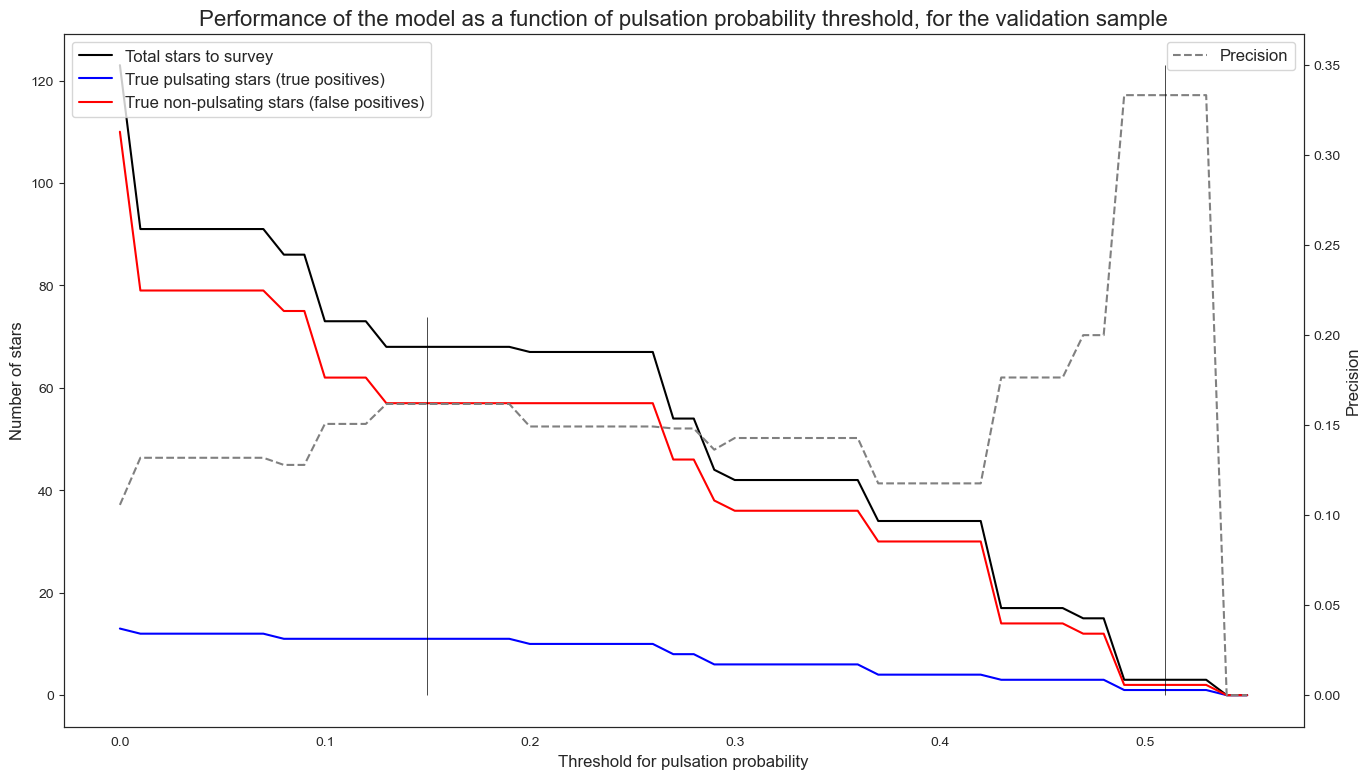

In [73]:
plt.figure(figsize=(10,7))
ax = p_det_df.plot(x='Detection threshold', y='Total stars to survey', color='black', legend=False)
p_det_df.plot(x='Detection threshold', y='True pulsating stars (true positives)', ax=ax, color='blue', legend=False)
p_det_df.plot(x='Detection threshold', y='True non-pulsating stars (false positives)', color='red', ax=ax, legend=False)
ax2 = ax.twinx()
p_det_df.plot(x='Detection threshold', y='Precision', color='gray', ls="--", ax=ax2, legend=True)
ax.figure.set_size_inches(16, 9)
#ax.figure.legend()
ax.legend(loc='upper left', fontsize=12)
ax.set_title("Performance of the model as a function of pulsation probability threshold, for the validation sample",
             fontsize=16)
ax.set_xlabel("Threshold for pulsation probability", fontsize=12)
ax.set_ylabel("Number of stars", fontsize=12)
ax2.set_ylabel("Precision", fontsize=12)
ax2.vlines(x=0.150, ymin=0.0, ymax=0.21, color='black', lw=0.5)
ax2.vlines(x=0.510, ymin=0.0, ymax=0.35, color='black', lw=0.5)
ax2.legend(loc='upper right', fontsize=12)
plt.savefig(IMG_FOLDER + "ML_90_05_ValPerformance_vs_DetThr.jpg")
plt.show()

In [74]:
good_thr_df = p_det_df[(p_det_df['Detection threshold'] == 0.150) | \
                       (p_det_df['Detection threshold'] == 0.510)].copy()
good_thr_df

,Detection threshold,Total stars to survey,True pulsating stars (true positives),True non-pulsating stars (false positives),Precision
15,0.15,68,11,57,0.161765
51,0.51,3,1,2,0.333333


In [75]:
good_thr_df['Precision'] = good_thr_df['Precision'].map(lambda x: np.round(x ,2))
good_thr_df

,Detection threshold,Total stars to survey,True pulsating stars (true positives),True non-pulsating stars (false positives),Precision
15,0.15,68,11,57,0.16
51,0.51,3,1,2,0.33


In [76]:
good_thr_df.T

,15,51
Detection threshold,0.15,0.51
Total stars to survey,68.00,3.00
True pulsating stars (true positives),11.00,1.00
True non-pulsating stars (false positives),57.00,2.00
Precision,0.16,0.33


In [77]:
print(
    good_thr_df.T.to_latex(
        index=True, longtable=False,
        caption=("Detections in validation sample with suggested thresholds.",
                 "Detections in validation sample with suggested thresholds.")
    )
)


\begin{table}
\centering
\caption[Detections in validation sample with suggested thresholds.]{Detections in validation sample with suggested thresholds.}
\begin{tabular}{lrr}
\toprule
{} &     15 &    51 \\
\midrule
Detection threshold                        &   0.15 &  0.51 \\
Total stars to survey                      &  68.00 &  3.00 \\
True pulsating stars (true positives)      &  11.00 &  1.00 \\
True non-pulsating stars (false positives) &  57.00 &  2.00 \\
Precision                                  &   0.16 &  0.33 \\
\bottomrule
\end{tabular}
\end{table}



C:\Users\ciroe\AppData\Local\Temp\ipykernel_1256\3504575572.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  good_thr_df.T.to_latex(


In [78]:
# Save to file:
# Write to file:
# Backup the standard output:
original_stdout = sys.stdout
with open(PROPOSED_THR_LATEX_OUT, 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.print(
    print(
        good_thr_df.T.to_latex(
            index=True, longtable=False,
            caption=("Detections in validation sample with suggested thresholds.",
                     "Detections in validation sample with suggested thresholds.")
        )
    )
# Restore the standard output to its original value
sys.stdout = original_stdout

C:\Users\ciroe\AppData\Local\Temp\ipykernel_1256\3545021458.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  good_thr_df.T.to_latex(


In [79]:
p_det_df.to_csv(THR_VAL_INFO_OUT, sep=',', decimal='.', index=False)

## Predictions for CARMENES stars

In [80]:
carm_pred_df.head()

,Karmn,Pulsation predicted,Pulsation probability
0,J23505-095,0,0.009009
1,J23492+024,0,0.009009
2,J23431+365,0,0.000000
3,J23419+441,0,0.000000
4,J23381-162,0,0.000000


### CARMENES stars labelled as pulsators

We now see the CARMENES stars labelled as pulsators when using the default probability threshold of $0.5$.

In [81]:
carm_pred_df[carm_pred_df['Pulsation predicted'] == 1]

,Karmn,Pulsation predicted,Pulsation probability
69,J16581+257,1,0.533333
161,J08126-215,1,0.533333


In [82]:
print(carm_pred_df.loc[carm_pred_df['Pulsation predicted'] == 1, ['Karmn', 'Pulsation probability']] \
        .to_latex(
            index=False, longtable=False,
            caption=("CARMENES stars detected as pulsators by the model.",
                     "CARMENES stars detected as pulsators by the model.")
    )
)


\begin{table}
\centering
\caption[CARMENES stars detected as pulsators by the model.]{CARMENES stars detected as pulsators by the model.}
\begin{tabular}{lr}
\toprule
     Karmn &  Pulsation probability \\
\midrule
J16581+257 &               0.533333 \\
J08126-215 &               0.533333 \\
\bottomrule
\end{tabular}
\end{table}



C:\Users\ciroe\AppData\Local\Temp\ipykernel_1256\3199734136.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(carm_pred_df.loc[carm_pred_df['Pulsation predicted'] == 1, ['Karmn', 'Pulsation probability']] \


In [83]:
# Save to file:
# Write to file:
# Backup the standard output:
original_stdout = sys.stdout
with open(CARMENES_DETECTED_LATEX_OUT, 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.print(
    print(carm_pred_df.loc[carm_pred_df['Pulsation predicted'] == 1, ['Karmn', 'Pulsation probability']] \
            .to_latex(
                index=False, longtable=False,
                caption=("CARMENES stars detected as pulsators by the model.",
                         "CARMENES stars detected as pulsators by the model.")
        )
    )
# Restore the standard output to its original value
sys.stdout = original_stdout

C:\Users\ciroe\AppData\Local\Temp\ipykernel_1256\2256004873.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(carm_pred_df.loc[carm_pred_df['Pulsation predicted'] == 1, ['Karmn', 'Pulsation probability']] \


### Threshold impact on predictions

In [84]:
carm_result_w_thr = carm_results.copy()
carm_result_w_thr.head()

,Karmn,Pulsation predicted,Pulsation probability,Name,Comp,GJ,RA_J2016_deg,DE_J2016_deg,RA_J2000,DE_J2000,...,LoRes_spectrum,HiRes_spectrum,LoRes_imaging,HiRes_imaging,Class,Survey,Notes,Gaia_id_1,2MASS_id,TIC_id
0,J23505-095,0,0.009009,LP 763-012,-,4367,357.634705,-9.560964,23:50:31.64,-09:33:32.7,...,NaN,FEROS,NaN,FastCam (Astralux),Alpha,GTO,NaN,2435125446129139712,23503159-0933320,9697711
1,J23492+024,0,0.009009,BR Psc,-,908,357.306604,2.396918,23:49:12.53,+02:24:04.4,...,NaN,CAFE FEROS,NaN,FastCam [WD15],Alpha,GTO,NaN,2739689239311660672,23491255+0224037,267255253
2,J23431+365,0,0.000000,GJ 1289,-,1289,355.781509,36.536310,23:43:06.31,+36:32:13.1,...,NaN,NaN,NaN,FastCam,Alpha,GTO,NaN,2879455480942629248,23430628+3632132,352593978
3,J23419+441,0,0.000000,HH And,-,905,355.480015,44.170376,23:41:55.04,+44:10:38.8,...,CAFOS,NaN,NaN,(Astralux) [LuckyCam],Alpha,GTO,NaN,1926461164913660160,23415498+4410407,2041185141
4,J23381-162,0,0.000000,G 273-093,-,4352,354.532687,-16.236514,23:38:08.16,-16:14:10.2,...,NaN,FEROS,NaN,FastCam,Alpha,GTO,NaN,2395413147718069504,23380819-1614100,434106275


In [85]:
carm_result_w_thr['Thr pulsation predicted'] = False
carm_result_w_thr

,Karmn,Pulsation predicted,Pulsation probability,Name,Comp,GJ,RA_J2016_deg,DE_J2016_deg,RA_J2000,DE_J2000,...,HiRes_spectrum,LoRes_imaging,HiRes_imaging,Class,Survey,Notes,Gaia_id_1,2MASS_id,TIC_id,Thr pulsation predicted
0,J23505-095,0,0.009009,LP 763-012,-,4367,357.634705,-9.560964,23:50:31.64,-09:33:32.7,...,FEROS,NaN,FastCam (Astralux),Alpha,GTO,NaN,2435125446129139712,23503159-0933320,9697711,False
1,J23492+024,0,0.009009,BR Psc,-,908,357.306604,2.396918,23:49:12.53,+02:24:04.4,...,CAFE FEROS,NaN,FastCam [WD15],Alpha,GTO,NaN,2739689239311660672,23491255+0224037,267255253,False
2,J23431+365,0,0.000000,GJ 1289,-,1289,355.781509,36.536310,23:43:06.31,+36:32:13.1,...,NaN,NaN,FastCam,Alpha,GTO,NaN,2879455480942629248,23430628+3632132,352593978,False
3,J23419+441,0,0.000000,HH And,-,905,355.480015,44.170376,23:41:55.04,+44:10:38.8,...,NaN,NaN,(Astralux) [LuckyCam],Alpha,GTO,NaN,1926461164913660160,23415498+4410407,2041185141,False
4,J23381-162,0,0.000000,G 273-093,-,4352,354.532687,-16.236514,23:38:08.16,-16:14:10.2,...,FEROS,NaN,FastCam,Alpha,GTO,NaN,2395413147718069504,23380819-1614100,434106275,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,J00184+440,0,0.285714,GQ And,B,15B,4.625301,44.028745,00:18:25.82,+44:01:38.1,...,NaN,TCP,FastCam,Alpha,GTO,NaN,385334196532776576,00182549+4401376,440109718,False
229,J00183+440,0,0.000000,GX And,A,15A,4.613226,44.024787,00:18:22.88,+44:01:22.6,...,NaN,TCP,FastCam [WD15],Alpha,GTO,NaN,385334230892516480,00182256+4401222,440109725,False
230,J00162+198E,0,0.000000,LP 404-062,B,1006B,4.070651,19.860692,00:16:16.15,+19:51:50.5,...,FEROS,TCP,(FastCam) (Astralux),Alpha,GTO,NaN,2797745549200773120,00161607+1951515,150899677,False
231,J00067-075,0,0.000000,GJ 1002,-,1002,1.676350,-7.546475,00:06:43.20,-07:32:17.0,...,NaN,NaN,FastCam,Alpha,GTO,NaN,2441630500517079808,00064325-0732147,176287658,False


In [86]:
# Maximum possible probability value
max_pc_thr_value_c = min(101, int(100.0 * carm_results['Pulsation probability'].max()))
max_pc_thr_value_c

53

**NOTE:** in this case, we only have the prediction of the model. We do not have the precision or the true labels for CARMENES. For the precision, we will assume that its value will be equal to the one achieved on the validation sample for each value of the prediction threshold. From this precision value and the total number of CARMENES stars predicted as pulsating, we will estimate the number of true pulsating stars we have in that total number of stars, for each value of the threshold.

In [87]:
thr_list = []
stars_to_survey_list = []

for pc_thr in range(0, 56):
    pred_thr = pc_thr / 100.0
    carm_result_w_thr['Thr pulsation predicted'] = \
        carm_result_w_thr['Pulsation probability'] > pred_thr
    carm_result_w_thr['Thr pulsation predicted'] \
        .map(lambda x: 1 if x == True else 0)
    y_pred = carm_result_w_thr['Thr pulsation predicted']
    total_stars_detected = len(carm_result_w_thr[carm_result_w_thr['Thr pulsation predicted'] == 1])
    
    thr_list.append(pred_thr)
    stars_to_survey_list.append(total_stars_detected)

p_det_carm_df = pd.DataFrame(
    data = {
        'Detection threshold': thr_list,
        'Total stars to survey': stars_to_survey_list,
        'True pulsating stars (true positives)': -1,
        'True non-pulsating stars (false positives)': -1,
        'Precision': 0.00
    }
)
p_det_carm_df.head()

,Detection threshold,Total stars to survey,True pulsating stars (true positives),True non-pulsating stars (false positives),Precision
0,0.00,118,-1,-1,0.0
1,0.01,87,-1,-1,0.0
2,0.02,87,-1,-1,0.0
3,0.03,87,-1,-1,0.0
4,0.04,87,-1,-1,0.0


Set the precision values equal to those for the validation sample.

In [88]:
p_det_carm_df.loc[:, 'Precision'] = p_det_df.loc[:, 'Precision']
p_det_carm_df.head()

,Detection threshold,Total stars to survey,True pulsating stars (true positives),True non-pulsating stars (false positives),Precision
0,0.00,118,-1,-1,0.105691
1,0.01,87,-1,-1,0.131868
2,0.02,87,-1,-1,0.131868
3,0.03,87,-1,-1,0.131868
4,0.04,87,-1,-1,0.131868


We now calculate the true positives, from the precision formula:

$precision=\frac{TP}{TP+FP}$

$TP=precision\times(TP+FP)=precision\times\;Predicted\_pulsators$

**Note:** we use a neutral approach, i.e. rounding the number of true pulsators detected to the nearest whole number.

In [89]:
p_det_carm_df['True pulsating stars (true positives)'] = \
    np.floor(p_det_carm_df['Total stars to survey'] * p_det_carm_df['Precision']).astype(int)
p_det_carm_df

,Detection threshold,Total stars to survey,True pulsating stars (true positives),True non-pulsating stars (false positives),Precision
0,0.00,118,12,-1,0.105691
1,0.01,87,11,-1,0.131868
2,0.02,87,11,-1,0.131868
3,0.03,87,11,-1,0.131868
4,0.04,87,11,-1,0.131868
5,0.05,87,11,-1,0.131868
6,0.06,87,11,-1,0.131868
7,0.07,87,11,-1,0.131868
8,0.08,82,10,-1,0.127907
9,0.09,82,10,-1,0.127907


And then, we can calculate the false positives:

$FP = Predicted\_pulsators - TP$

In [90]:
p_det_carm_df['True non-pulsating stars (false positives)'] = \
    p_det_carm_df['Total stars to survey'] - p_det_carm_df['True pulsating stars (true positives)']
p_det_carm_df

,Detection threshold,Total stars to survey,True pulsating stars (true positives),True non-pulsating stars (false positives),Precision
0,0.00,118,12,106,0.105691
1,0.01,87,11,76,0.131868
2,0.02,87,11,76,0.131868
3,0.03,87,11,76,0.131868
4,0.04,87,11,76,0.131868
5,0.05,87,11,76,0.131868
6,0.06,87,11,76,0.131868
7,0.07,87,11,76,0.131868
8,0.08,82,10,72,0.127907
9,0.09,82,10,72,0.127907


In [91]:
p_det_carm_df.columns

Index(['Detection threshold', 'Total stars to survey',
       'True pulsating stars (true positives)',
       'True non-pulsating stars (false positives)', 'Precision'],
      dtype='object')

In [92]:
p_det_carm_df.rename(
    columns={
        'True pulsating stars (true positives)': 'Estimated true pulsating stars',
        'True non-pulsating stars (false positives)': 'Estimated true non-pulsating stars'
    },
    inplace=True
)
p_det_carm_df.head()

,Detection threshold,Total stars to survey,Estimated true pulsating stars,Estimated true non-pulsating stars,Precision
0,0.00,118,12,106,0.105691
1,0.01,87,11,76,0.131868
2,0.02,87,11,76,0.131868
3,0.03,87,11,76,0.131868
4,0.04,87,11,76,0.131868


<Figure size 1000x700 with 0 Axes>

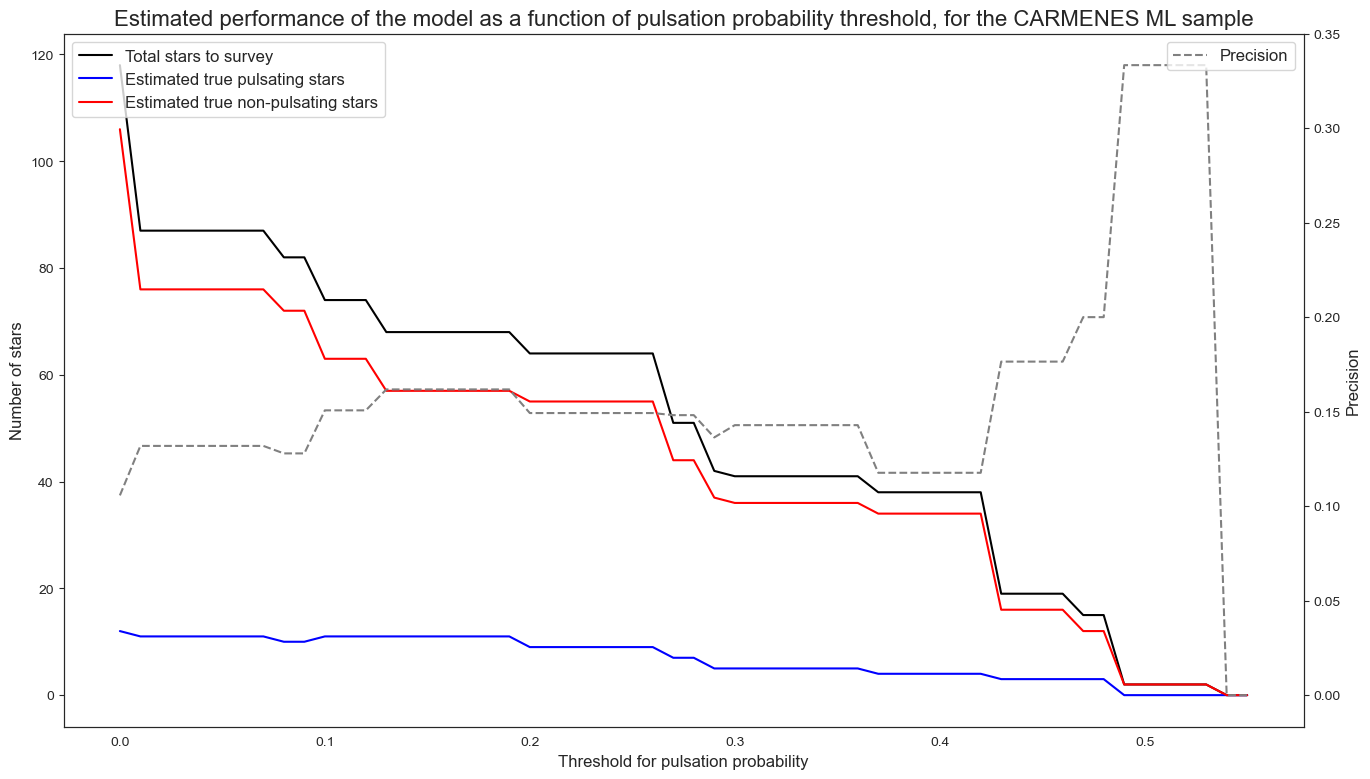

In [93]:
plt.figure(figsize=(10,7))
ax = p_det_carm_df.plot(x='Detection threshold', y='Total stars to survey', color='black', legend=False)
p_det_carm_df.plot(x='Detection threshold', y='Estimated true pulsating stars', ax=ax, color='blue', legend=False)
p_det_carm_df.plot(x='Detection threshold', y='Estimated true non-pulsating stars', color='red', ax=ax, legend=False)
ax2 = ax.twinx()
p_det_carm_df.plot(x='Detection threshold', y='Precision', color='gray', ls="--", ax=ax2, legend=True)
ax.figure.set_size_inches(16, 9)
#ax.figure.legend()
ax.legend(loc='upper left', fontsize=12)
ax.set_title("Estimated performance of the model as a function of pulsation probability threshold," \
             " for the CARMENES ML sample",
             fontsize=16)
ax.set_xlabel("Threshold for pulsation probability", fontsize=12)
ax.set_ylabel("Number of stars", fontsize=12)
ax2.set_ylabel("Precision", fontsize=12)
#ax2.vlines(x=0.150, ymin=0.0, ymax=0.21, color='black', lw=0.5)
#ax2.vlines(x=0.510, ymin=0.0, ymax=0.35, color='black', lw=0.5)
ax2.legend(loc='upper right', fontsize=12)
plt.savefig(IMG_FOLDER + "ML_90_06_CarmenesPerformance_vs_DetThr.jpg")
plt.show()


In [94]:
p_det_carm_df.to_csv(THR_CARMENES_INFO_OUT, sep=',', decimal='.', index=False)

### Compare validation sample and CARMENES sample

In [95]:
p_det_carm_df2 = p_det_carm_df.rename(
    columns={
        'Total stars to survey': 'CARMENES: stars to survey',
        'Estimated true pulsating stars': 'CARMENES: estimated pulsating stars in survey',
        'Estimated true non-pulsating stars': 'CARMENES: estimated non-pulsating stars in survey'
    }
)

In [96]:
p_det_carm_df2.columns

Index(['Detection threshold', 'CARMENES: stars to survey',
       'CARMENES: estimated pulsating stars in survey',
       'CARMENES: estimated non-pulsating stars in survey', 'Precision'],
      dtype='object')

In [97]:
p_det_df2 = p_det_df.rename(
    columns={
        'Total stars to survey': 'Validation S4: stars labelled as pulsating',
        'True pulsating stars (true positives)': 'Validation S4: true pulsators labelled as pulsators (TP)',
        'True non-pulsating stars (false positives)': 'Validation S4: true non-pulsators labelled as pulsators (FP)'
    }
)

In [98]:
p_det_df2.columns

Index(['Detection threshold', 'Validation S4: stars labelled as pulsating',
       'Validation S4: true pulsators labelled as pulsators (TP)',
       'Validation S4: true non-pulsators labelled as pulsators (FP)',
       'Precision'],
      dtype='object')

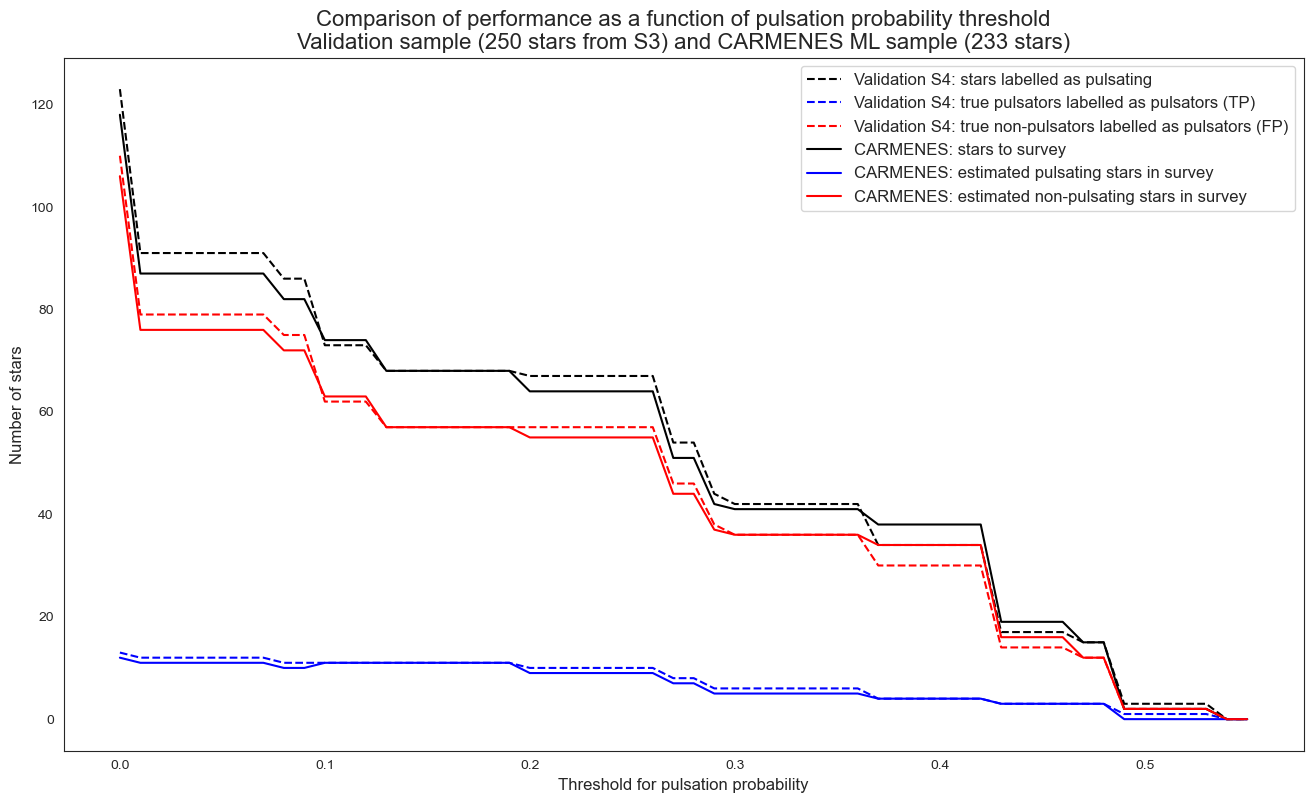

In [99]:
ax = p_det_df2.plot(x='Detection threshold', y='Validation S4: stars labelled as pulsating',
                    color='black', ls='--', legend=False)
p_det_df2.plot(x='Detection threshold', y='Validation S4: true pulsators labelled as pulsators (TP)', 
               color='blue', ls='--', legend=False, ax=ax)
p_det_df2.plot(x='Detection threshold', y='Validation S4: true non-pulsators labelled as pulsators (FP)',
               color='red', ls='--', legend=False, ax=ax)
p_det_carm_df2.plot(x='Detection threshold', y='CARMENES: stars to survey',
                    color='black', legend=False, ax=ax)
p_det_carm_df2.plot(x='Detection threshold', y='CARMENES: estimated pulsating stars in survey',
                    color='blue', legend=False, ax=ax)
p_det_carm_df2.plot(x='Detection threshold', y='CARMENES: estimated non-pulsating stars in survey',
                    color='red', legend=False, ax=ax)
ax.figure.set_size_inches(16, 9)
#ax.figure.legend()
ax.legend(loc='upper right', fontsize=12)
ax.set_title("Comparison of performance as a function of pulsation probability threshold\n" \
             "Validation sample (250 stars from S3) and CARMENES ML sample (233 stars)",
             fontsize=16)
ax.set_xlabel("Threshold for pulsation probability", fontsize=12)
ax.set_ylabel("Number of stars", fontsize=12)
plt.savefig(IMG_FOLDER + "ML_90_07_Carmenes_vs_Validation_Performance_vs_DetThr.jpg")
plt.show()

And now, with only the black lines (i.e. stars labelled as pulsators by the model):

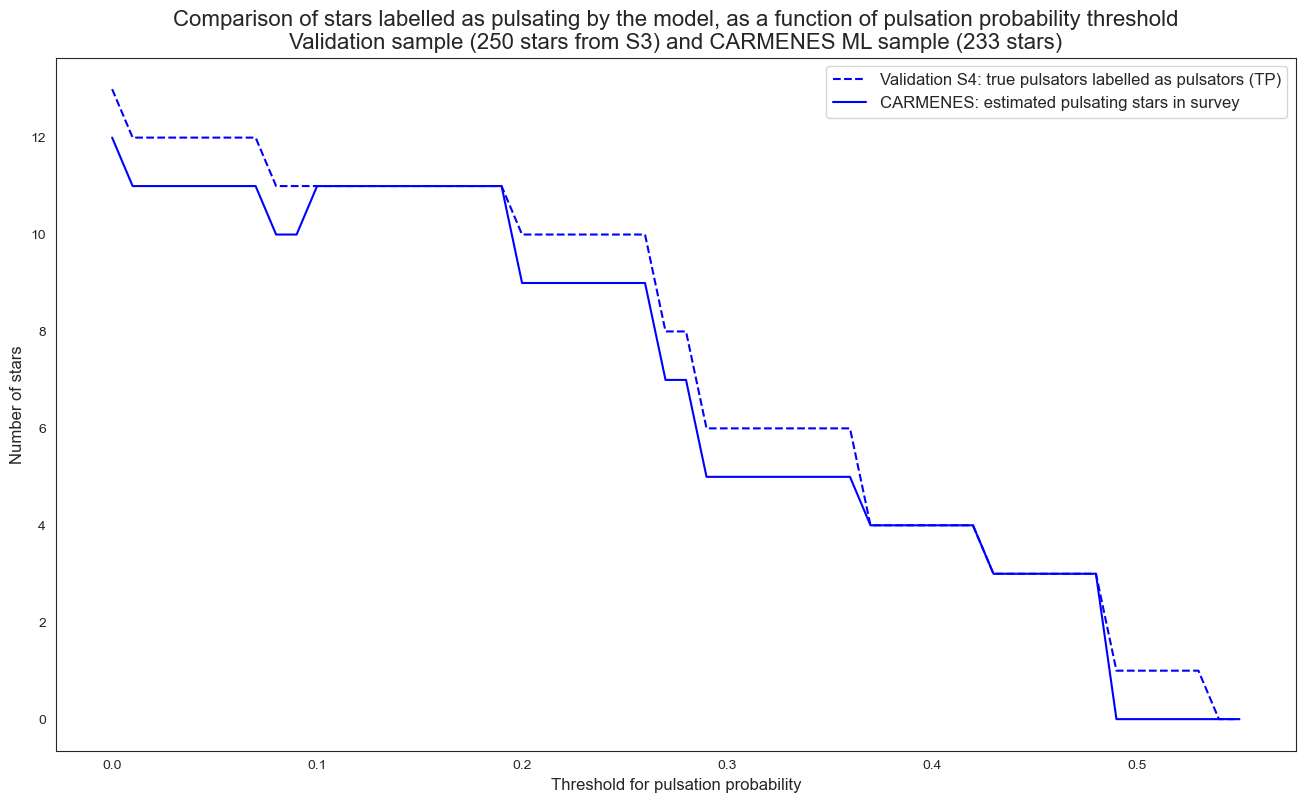

In [101]:
### ERROR - THESE ARE THE BLUE LINES:
ax = p_det_df2.plot(x='Detection threshold', y='Validation S4: true pulsators labelled as pulsators (TP)', 
               color='blue', ls='--', legend=False)
p_det_carm_df2.plot(x='Detection threshold', y='CARMENES: estimated pulsating stars in survey',
                    color='blue', legend=False, ax=ax)
ax.figure.set_size_inches(16, 9)
#ax.figure.legend()
ax.legend(loc='upper right', fontsize=12)
ax.set_title("Comparison of stars labelled as pulsating by the model, as a function of pulsation probability threshold\n" \
             "Validation sample (250 stars from S3) and CARMENES ML sample (233 stars)",
             fontsize=16)
ax.set_xlabel("Threshold for pulsation probability", fontsize=12)
ax.set_ylabel("Number of stars", fontsize=12)
plt.savefig(IMG_FOLDER + "ML_90_08_WRONG_Carmenes_vs_Validation_PulsatorsLabelled_vs_DetThr.jpg")
plt.show()

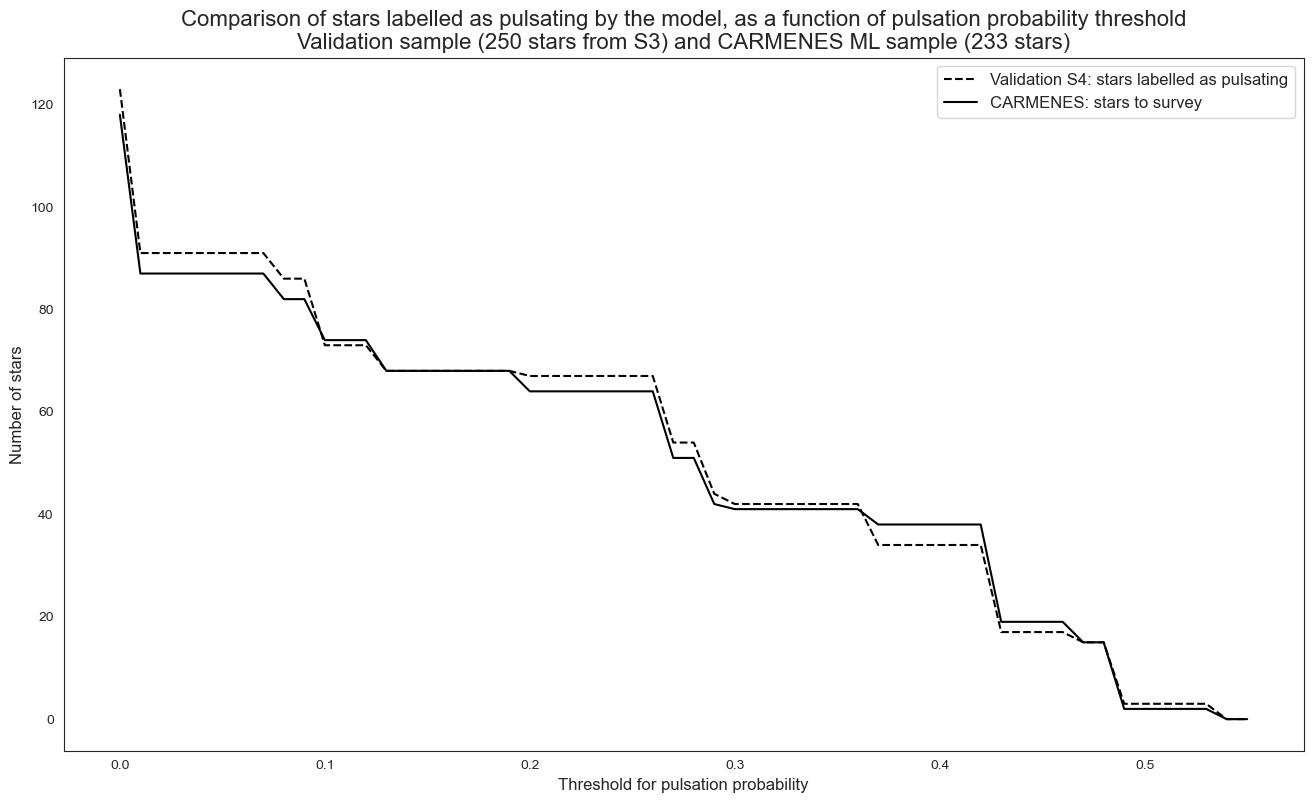

In [102]:
ax = p_det_df2.plot(x='Detection threshold', y='Validation S4: stars labelled as pulsating', 
               color='black', ls='--', legend=False)
p_det_carm_df2.plot(x='Detection threshold', y='CARMENES: stars to survey',
                    color='black', legend=False, ax=ax)
ax.figure.set_size_inches(16, 9)
#ax.figure.legend()
ax.legend(loc='upper right', fontsize=12)
ax.set_title("Comparison of stars labelled as pulsating by the model, as a function of pulsation probability threshold\n" \
             "Validation sample (250 stars from S3) and CARMENES ML sample (233 stars)",
             fontsize=16)
ax.set_xlabel("Threshold for pulsation probability", fontsize=12)
ax.set_ylabel("Number of stars", fontsize=12)
plt.savefig(IMG_FOLDER + "ML_90_08_Carmenes_vs_Validation_PulsatorsLabelled_vs_DetThr.jpg")
plt.show()

### Get table of estimations for CARMMENES

In [103]:
p_det_carm_df.columns

Index(['Detection threshold', 'Total stars to survey',
       'Estimated true pulsating stars', 'Estimated true non-pulsating stars',
       'Precision'],
      dtype='object')

In [104]:
p_det_unique_combinations = p_det_carm_df.drop_duplicates(
    subset=[
        'Total stars to survey',
        'Estimated true pulsating stars',
        'Estimated true non-pulsating stars',
        'Precision'
    ],
    keep='first')
p_det_unique_combinations

,Detection threshold,Total stars to survey,Estimated true pulsating stars,Estimated true non-pulsating stars,Precision
0,0.00,118,12,106,0.105691
1,0.01,87,11,76,0.131868
8,0.08,82,10,72,0.127907
10,0.10,74,11,63,0.150685
13,0.13,68,11,57,0.161765
20,0.20,64,9,55,0.149254
27,0.27,51,7,44,0.148148
29,0.29,42,5,37,0.136364
30,0.30,41,5,36,0.142857
37,0.37,38,4,34,0.117647


In [105]:
p_det_unique_combinations.to_csv(CARMENES_ESTIMATIONS_OUT, sep=',', decimal='.', index=False)

In [106]:
print(
    p_det_unique_combinations.drop(columns=['Precision']).to_latex(
        index=False, longtable=False,
        caption=("Estimations of pulsators detections in CARMENES, for different thresholds.",
                 "Estimations of pulsators detections in CARMENES, for different thresholds.")
    )
)


\begin{table}
\centering
\caption[Estimations of pulsators detections in CARMENES, for different thresholds.]{Estimations of pulsators detections in CARMENES, for different thresholds.}
\begin{tabular}{rrrr}
\toprule
 Detection threshold &  Total stars to survey &  Estimated true pulsating stars &  Estimated true non-pulsating stars \\
\midrule
                0.00 &                    118 &                              12 &                                 106 \\
                0.01 &                     87 &                              11 &                                  76 \\
                0.08 &                     82 &                              10 &                                  72 \\
                0.10 &                     74 &                              11 &                                  63 \\
                0.13 &                     68 &                              11 &                                  57 \\
                0.20 &                     64 & 

C:\Users\ciroe\AppData\Local\Temp\ipykernel_1256\2980776804.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  p_det_unique_combinations.drop(columns=['Precision']).to_latex(


In [107]:
# Save to file:
# Write to file:
# Backup the standard output:
original_stdout = sys.stdout
with open(CARMENES_ESTIMATIONS_LATEX_OUT, 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.print(
    print(
        p_det_unique_combinations.drop(columns=['Precision']).to_latex(
            index=False, longtable=False,
            caption=("Estimations of pulsators detections in CARMENES, for different thresholds.",
                     "Estimations of pulsators detections in CARMENES, for different thresholds.")
        )
    )
# Restore the standard output to its original value
sys.stdout = original_stdout

C:\Users\ciroe\AppData\Local\Temp\ipykernel_1256\783385679.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  p_det_unique_combinations.drop(columns=['Precision']).to_latex(


## Summary

**RESULTS:**

- We have completed the analysis of `DecisionTreeClassifier` model.
